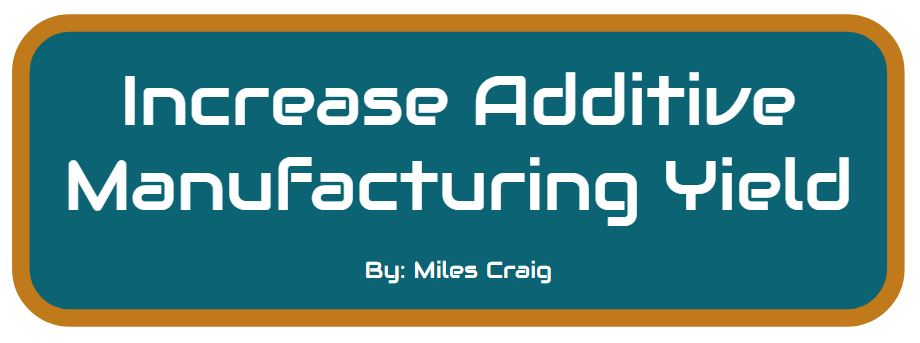

In [1]:
# Title picture
from IPython.display import Image
Image(filename='images/import/title_pic.jpg')

# Python Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # for reading csv files
import glob # for reading csv files
import math # for trig on angles
import re # to search strings for nums
from functools import reduce # to combine final dfs into a single df

# Constants

In [3]:
# Constants used throughout the project

# colors use in presentation and graphs
colors = {'blue':'#0b6374', 'orange':'#c0791b', 'gray':'#666666'} 
# color picker = https://www.w3schools.com/colors/colors_picker.asp

# plot title font size
tt_fs = 20 

# the layer height(mm) for the print was held constant
layer_height = 0.03 

# convert pixels to microns     
scale_factor = 29.2 # microns per pixel normal to print surface
incident_angle = 9.1 # degrees
pix_mic_x = scale_factor / math.cos(math.radians(incident_angle))
pix_mic_y = scale_factor
pix_mic_a = pix_mic_x * pix_mic_y

# temperature thresholds (C) used to calculate melt pool metrics
mpm_thresh_temps = {'t1':1600,'t2':1800,'t3':2000,'t4':2200} 

# Print Parameters (pp)

In [4]:
# print parameters are settings used to print the part

# read print parameters (PP) file
pp = pd.read_csv('data/raw/pp/print_parameters.csv', index_col=0)

# set column type to category
pp['cond_type'] = pp['cond_type'].astype('category') 

# calculate energy densities in pp df
# LED = linear laser energy density
# GED = global energy density
# VED = volumetric laser energy density

# calculate LED
# LED = LP/SS
pp['led'] = (pp['laser_power(W)'] / pp['scan_speed(mm/s)']).round(2) 

# calculate GED
# GED = LP/(SS*HS)
pp['ged'] = (pp['laser_power(W)'] / \
    (pp['scan_speed(mm/s)'] * pp['hatch_spacing(mm)'])).round(2) 

# calculate VED
# VED = LP/(SS*HS*LH)
pp['ved'] = (pp['laser_power(W)'] / \
    (pp['scan_speed(mm/s)'] * pp['hatch_spacing(mm)'] * layer_height )).round(2) 

print('PRINT PARAMETERS')
pp

PRINT PARAMETERS


,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved
condition,,,,,,,
1,325,1650,0.09,PV,0.20,2.19,72.95
2,300,1650,0.09,PV,0.18,2.02,67.34
3,275,1650,0.09,PV,0.17,1.85,61.73
4,180,1650,0.09,PV,0.11,1.21,40.40
5,120,1650,0.09,PV,0.07,0.81,26.94
6,370,3780,0.14,SV,0.10,0.70,23.31
7,370,3000,0.14,SV,0.12,0.88,29.37
8,370,2200,0.14,SV,0.17,1.20,40.04
9,370,1320,0.14,SV,0.28,2.00,66.74


# Run Log (runs)

In [5]:
# Run log is data collected about the acquisition
# of the melt pool metrics during the build

# read Run Log (runs) file
runs = pd.read_csv('data/raw/runs/runs.csv', index_col=0)
runs['date'] = pd.to_datetime(runs['date'])

# create new column
runs.insert(loc=9, column='window_type', value='')

# create window type column based on window size (w,h)
for i, r in runs.iterrows():
    w = r['window_w(pixels)']
    h = r['window_h(pixels)']   
    
    if w==384 and h==370:
        w_type = 'full'
    elif w==384 and h==80:
        w_type = 'quart_1'
    elif w==80 and h==370:
        w_type = 'quart_2'
    runs.loc[i,'window_type'] = w_type

# set column type to category
runs['window_type'] = runs['window_type'].astype('category') 

print('RUN LOG')
runs

RUN LOG


,date,condition,build_height(mm),num_of_layers,frames_per_layer,window_x(pixels),window_y(pixels),window_w(pixels),window_h(pixels),window_type,frame_rate(Hz),exp_time(ms),delay(ms)
run,,,,,,,,,,,,,
16,2018-04-24,1,0.03,1,800,312,302,384,370,full,800,0.024957,675
17,2018-04-24,1,0.48,20,800,312,302,384,370,full,800,0.024957,675
18,2018-04-24,1,2.70,20,1000,312,447,384,80,quart_1,3200,0.024957,950
19,2018-04-24,1,3.81,20,1000,464,302,80,370,quart_2,3200,0.024957,950
20,2018-04-24,2,5.19,20,800,312,302,384,370,full,800,0.024957,675
21,2018-04-24,2,6.93,20,1000,312,447,384,80,quart_1,3200,0.024957,950
22,2018-04-24,2,8.16,20,1000,464,302,80,370,quart_2,3200,0.024957,950
23,2018-04-24,3,10.26,20,800,312,302,384,370,full,800,0.024957,675
24,2018-04-24,3,11.88,20,1000,312,447,384,80,quart_1,3200,0.024957,950


# Material Properties (mp)

In [6]:
# Read Material Properties (MP) file
# Material properties file containing porosity
# Technically November 14/15, 2017 data

mp = pd.read_csv('data/raw/mp/porosity.csv', index_col=0)
print('MATERIAL PROPERTIES')
mp

MATERIAL PROPERTIES


,porosity(%)
condition,
1,0.039
2,0.068
3,0.067
4,1.189
5,9.860
6,8.060
7,6.225
8,1.630
9,0.115


# Melt Pool Metrics (mpm)

## Read MPM Column Labels

In [7]:
# viz col labels
viz_col = list(pd.read_csv('data/raw/mpm/cols/viz_cols.csv',
                           header=None).values.T.flatten()) 

viz_col

['run',
 'frame',
 'time(s)',
 'exp_time(ms)',
 'int_s_p(counts)',
 'int_l_p(counts)',
 'int_s_avg_3(counts)',
 'int_l_avg_3(counts)',
 'int_s_avg_5(counts)',
 'int_l_avg_5(counts)',
 'region_mean_short(counts)',
 'region_mean_long(counts)',
 'temp_hybref(C)',
 'temp_peak(C)',
 'loc_x(pixels)',
 'loc_y(pixels)',
 'layer',
 'scan_direction(012)']

In [8]:
# threshold col labels
thresh_col = list(pd.read_csv('data/raw/mpm/cols/thresh_cols.csv',
                              header=None).values.T.flatten()) 

thresh_col

['run',
 'frame',
 't1_temp_avg(C)',
 't1_length(pixels)',
 't1_width(pixels)',
 't1_orient(degrees)',
 't1_area(pixels)',
 't1_sat_num(-)',
 't1_sat_area(pixels)',
 't2_temp_avg(C)',
 't2_length(pixels)',
 't2_width(pixels)',
 't2_orient(degrees)',
 't2_area(pixels)',
 't2_sat_num(-)',
 't2_sat_area(pixels)',
 't3_temp_avg(C)',
 't3_length(pixels)',
 't3_width(pixels)',
 't3_orient(degrees)',
 't3_area(pixels)',
 't3_sat_num(-)',
 't3_sat_area(pixels)',
 't4_temp_avg(C)',
 't4_length(pixels)',
 't4_width(pixels)',
 't4_orient(degrees)',
 't4_area(pixels)',
 't4_sat_num(-)',
 't4_sat_area(pixels)']

## Read MPM Tables (v,t)

In [9]:
# viz (v)
# threshold (t)
# v and t are side by side tables with identical indexes
# but different column labels for different data

# empty dictionary to read in raw mpm csv files
mpm_runs = {} 

# file path for csv files
path = r'data/raw/mpm/data' 

# list of file names to be read
all_files = glob.glob(os.path.join(path, "*.csv")) 

for f in all_files:
    
    # search for #s in file name
    run_nums = list(map(int, re.findall('\d+', f))) 
    
    if 'viz' in f:
        vt = 'v'
        col_names = viz_col
    elif 'thresh' in f:
        vt = 't'
        col_names = thresh_col
    
    # name dictionary key
    key = 'mpm_runs_%d-%d_%s' % (run_nums[1], run_nums[2], vt)
    
    # add df name to dict, read and add df as value, label columns
    mpm_runs[key] = pd.read_csv(f, names=col_names, header=None)

In [10]:
print('Example viz table')
mpm_runs['mpm_runs_16-19_v'].head()

Example viz table


,run,frame,time(s),exp_time(ms),int_s_p(counts),int_l_p(counts),int_s_avg_3(counts),int_l_avg_3(counts),int_s_avg_5(counts),int_l_avg_5(counts),region_mean_short(counts),region_mean_long(counts),temp_hybref(C),temp_peak(C),loc_x(pixels),loc_y(pixels),layer,scan_direction(012)
0,16,51,0.064,0.024957,2788,1533,2010.1,1073.4,1335.9,737.80,2235.8,1194.3,3117.0,3254.0,362,62,1,2
1,16,52,0.065,0.024957,2969,1579,1989.0,1177.9,1239.7,776.68,2341.1,1198.3,3319.9,3486.3,363,133,1,2
2,16,53,0.066,0.024957,3185,1719,2259.8,1218.9,1390.6,790.48,2484.4,1379.0,2952.9,3093.1,364,203,1,2
3,16,54,0.068,0.024957,3173,1783,2288.6,1375.7,1423.5,852.04,2471.1,1443.3,2758.2,2882.6,366,274,1,2
4,16,55,0.069,0.024957,3149,1901,2478.2,1219.0,1446.3,762.52,2513.1,1560.5,2553.4,2650.4,367,344,1,2


In [11]:
print('Example threshold table')
mpm_runs['mpm_runs_16-19_t'].head()

Example threshold table


,run,frame,t1_temp_avg(C),t1_length(pixels),t1_width(pixels),t1_orient(degrees),t1_area(pixels),t1_sat_num(-),t1_sat_area(pixels),t2_temp_avg(C),...,t3_area(pixels),t3_sat_num(-),t3_sat_area(pixels),t4_temp_avg(C),t4_length(pixels),t4_width(pixels),t4_orient(degrees),t4_area(pixels),t4_sat_num(-),t4_sat_area(pixels)
0,16,51,1834.1,79.429,19.615,-84.970,931,5,18,2058.8,...,134,7,16,2533.7,11.7200,7.4621,78.602,62,0,0
1,16,52,1856.9,72.962,21.994,-86.215,1036,18,50,2071.7,...,172,4,23,2540.6,16.5470,7.7379,84.588,88,0,0
2,16,53,1842.3,58.080,14.408,88.929,525,13,98,2079.6,...,77,2,4,2546.9,9.8077,5.9098,83.453,43,0,0
3,16,54,1853.2,39.585,12.303,-88.745,324,16,60,2051.6,...,55,0,0,2527.4,7.3917,5.0376,-88.601,28,0,0
4,16,55,1804.5,32.979,11.086,89.202,230,7,25,2050.8,...,33,0,0,2449.8,5.3287,3.9391,-68.395,15,0,0


## Combine v & t, horizontally

In [12]:
# empty dictionary to combine mpm(v/t) dfs
mpm_temp = {} 

# run through keys of mpm_runs
for x in list(mpm_runs.keys()): 
    
    # only combine v with t, not t with v, otherwise there are duplicate dfs
    if 'v' in x: 
        v_nums = list(map(int, re.findall('\d+', x))) # search for #s in df name
        
        for y in list(mpm_runs.keys()):
            t_nums = list(map(int, re.findall('\d+', y))) # search for #s in df name
            
            if v_nums == t_nums and 't' in y:
                # name df, drop v and t notations
                combine_name = 'mpm_runs_%d-%d' % (v_nums[0], v_nums[1]) 
                
                # drop duplicate columns between v and t
                mpm_runs.get(y).drop(['run', 'frame'], axis=1, inplace=True) 
                
                # join v and t, and add to dict
                mpm_temp[combine_name] = pd.concat([mpm_runs.get(x), mpm_runs.get(y)], axis=1) 

# set mpm_runs equal to the temporary df                
mpm_runs = mpm_temp

print('Example mpm_runs table')
mpm_runs['mpm_runs_16-19'].head()

Example mpm_runs table


,run,frame,time(s),exp_time(ms),int_s_p(counts),int_l_p(counts),int_s_avg_3(counts),int_l_avg_3(counts),int_s_avg_5(counts),int_l_avg_5(counts),...,t3_area(pixels),t3_sat_num(-),t3_sat_area(pixels),t4_temp_avg(C),t4_length(pixels),t4_width(pixels),t4_orient(degrees),t4_area(pixels),t4_sat_num(-),t4_sat_area(pixels)
0,16,51,0.064,0.024957,2788,1533,2010.1,1073.4,1335.9,737.80,...,134,7,16,2533.7,11.7200,7.4621,78.602,62,0,0
1,16,52,0.065,0.024957,2969,1579,1989.0,1177.9,1239.7,776.68,...,172,4,23,2540.6,16.5470,7.7379,84.588,88,0,0
2,16,53,0.066,0.024957,3185,1719,2259.8,1218.9,1390.6,790.48,...,77,2,4,2546.9,9.8077,5.9098,83.453,43,0,0
3,16,54,0.068,0.024957,3173,1783,2288.6,1375.7,1423.5,852.04,...,55,0,0,2527.4,7.3917,5.0376,-88.601,28,0,0
4,16,55,0.069,0.024957,3149,1901,2478.2,1219.0,1446.3,762.52,...,33,0,0,2449.8,5.3287,3.9391,-68.395,15,0,0


## Split MPM Tables per Run, Vertically

In [13]:
# empty dictionary to split dfs per run
mpm_temp = {} 

# run through keys of mpm_runs
for x in list(mpm_runs.keys()): 
    
    run_nums = list(map(int, re.findall('\d+', x))) # search for #s in file name
    run_nums = range(run_nums[0], run_nums[-1]+1) # list of #s in the range 'Runs_n-m'
    
    # run through the list of run numbers
    for y in run_nums: 
        key = 'mpm_run_%d' % (y) # name df per run
        mpm_temp[key] = mpm_runs.get(x)[mpm_runs.get(x)['run'] == y] #split df per run

# set mpm_runs equal to the temporary df        
mpm_runs = mpm_temp 

print('Example mpm_run table')
mpm_runs['mpm_run_16'].head()

Example mpm_run table


,run,frame,time(s),exp_time(ms),int_s_p(counts),int_l_p(counts),int_s_avg_3(counts),int_l_avg_3(counts),int_s_avg_5(counts),int_l_avg_5(counts),...,t3_area(pixels),t3_sat_num(-),t3_sat_area(pixels),t4_temp_avg(C),t4_length(pixels),t4_width(pixels),t4_orient(degrees),t4_area(pixels),t4_sat_num(-),t4_sat_area(pixels)
0,16,51,0.064,0.024957,2788,1533,2010.1,1073.4,1335.9,737.80,...,134,7,16,2533.7,11.7200,7.4621,78.602,62,0,0
1,16,52,0.065,0.024957,2969,1579,1989.0,1177.9,1239.7,776.68,...,172,4,23,2540.6,16.5470,7.7379,84.588,88,0,0
2,16,53,0.066,0.024957,3185,1719,2259.8,1218.9,1390.6,790.48,...,77,2,4,2546.9,9.8077,5.9098,83.453,43,0,0
3,16,54,0.068,0.024957,3173,1783,2288.6,1375.7,1423.5,852.04,...,55,0,0,2527.4,7.3917,5.0376,-88.601,28,0,0
4,16,55,0.069,0.024957,3149,1901,2478.2,1219.0,1446.3,762.52,...,33,0,0,2449.8,5.3287,3.9391,-68.395,15,0,0


## Create Condition Num Column

In [14]:
# create a dict from runs df, condition vs run
cond_run = dict(zip(runs.index, runs.condition)) 

# run through keys of mpm_runs
for x in list(mpm_runs.keys()): 
    
    # search for num in df_x name
    run_num = list(map(int, re.findall('\d+', x)))[0] 
    
    # set condition number based on run number of mpm_runs df
    cond_num = cond_run[run_num] 
    
    # create condition col in mpm_runs df
    mpm_runs.get(x).insert(loc=0, column='condition', value=cond_num) 
    
print('Example mpm_run table with added run num col and cond num col')
mpm_runs['mpm_run_16'].head()

Example mpm_run table with added run num col and cond num col


,condition,run,frame,time(s),exp_time(ms),int_s_p(counts),int_l_p(counts),int_s_avg_3(counts),int_l_avg_3(counts),int_s_avg_5(counts),...,t3_area(pixels),t3_sat_num(-),t3_sat_area(pixels),t4_temp_avg(C),t4_length(pixels),t4_width(pixels),t4_orient(degrees),t4_area(pixels),t4_sat_num(-),t4_sat_area(pixels)
0,1,16,51,0.064,0.024957,2788,1533,2010.1,1073.4,1335.9,...,134,7,16,2533.7,11.7200,7.4621,78.602,62,0,0
1,1,16,52,0.065,0.024957,2969,1579,1989.0,1177.9,1239.7,...,172,4,23,2540.6,16.5470,7.7379,84.588,88,0,0
2,1,16,53,0.066,0.024957,3185,1719,2259.8,1218.9,1390.6,...,77,2,4,2546.9,9.8077,5.9098,83.453,43,0,0
3,1,16,54,0.068,0.024957,3173,1783,2288.6,1375.7,1423.5,...,55,0,0,2527.4,7.3917,5.0376,-88.601,28,0,0
4,1,16,55,0.069,0.024957,3149,1901,2478.2,1219.0,1446.3,...,33,0,0,2449.8,5.3287,3.9391,-68.395,15,0,0


## Combine All MPM Tables into a Single Table

In [15]:
# combine add dfs from mpm_runs into a single df, vertically
mpm = pd.concat(mpm_runs.values(), ignore_index=True) 

# set a multi-index in mpm
mpm = mpm.set_index(['condition','run','layer','frame']) 

print('mpm table, a combination of all the mpm data into a single table')
mpm.head()

mpm table, a combination of all the mpm data into a single table


time(s)  exp_time(ms)  int_s_p(counts)  \
condition run layer frame                                           
1         16  1     51       0.064      0.024957             2788   
                    52       0.065      0.024957             2969   
                    53       0.066      0.024957             3185   
                    54       0.068      0.024957             3173   
                    55       0.069      0.024957             3149   

                           int_l_p(counts)  int_s_avg_3(counts)  \
condition run layer frame                                         
1         16  1     51                1533               2010.1   
                    52                1579               1989.0   
                    53                1719               2259.8   
                    54                1783               2288.6   
                    55                1901               2478.2   

                           int_l_avg_3(counts)  int_s_avg_5(counts)  \
condition run layer frame                                             
1         16  1     51                  1073.4               1335.9   
                    52                  1177.9               1239.7   
                    53                  1218.9               1390.6   
                    54                  1375.7               1423.5   
                    55                  1219.0               1446.3   

                           int_l_avg_5(counts)  region_mean_short(counts)  \
condition run layer frame                                                   
1         16  1     51                  737.80                     2235.8   
                    52                  776.68                     2341.1   
                    53                  790.48                     2484.4   
                    54                  852.04                     2471.1   
                    55                  762.52                     2513.1   

                           region_mean_long(counts)         ...           \
condition run layer frame                                   ...            
1         16  1     51                       1194.3         ...            
                    52                       1198.3         ...            
                    53                       1379.0         ...            
                    54                       1443.3         ...            
                    55                       1560.5         ...            

                           t3_area(pixels)  t3_sat_num(-)  \
condition run layer frame                                   
1         16  1     51                 134              7   
                    52                 172              4   
                    53                  77              2   
                    54                  55              0   
                    55                  33              0   

                           t3_sat_area(pixels)  t4_temp_avg(C)  \
condition run layer frame                                        
1         16  1     51                      16          2533.7   
                    52                      23          2540.6   
                    53                       4          2546.9   
                    54                       0          2527.4   
                    55                       0          2449.8   

                           t4_length(pixels)  t4_width(pixels)  \
condition run layer frame                                        
1         16  1     51               11.7200            7.4621   
                    52               16.5470            7.7379   
                    53                9.8077            5.9098   
                    54                7.3917            5.0376   
                    55                5.3287            3.9391   

                           t4_orient(degrees)  t4_area(pixels)  t4_sat_num(-)  \
condition run layer frame                                          

# Data Wrangling

## Scan Direction

In [16]:
# Convert 'scan_direction(012)' into 'scan_direction(xy)'
# Update column label
# Categorize the column

# delete all rows for 0/contours, only analyze internal melt pools
mpm = mpm[mpm['scan_direction(012)'] != 0] 

# dictionary used to convert 012 into xy (x-axis, y-axis)
scan_dir_conv = {1:'x',2:'y'} 

# use scan dict to convert 012 into xy
mpm['scan_direction(012)'].replace(scan_dir_conv, inplace=True) 


# rename column with xy instead of 012
mpm.rename(columns={'scan_direction(012)':'scan_direction(xy)'}, inplace=True) 

# set column type to category
mpm['scan_direction(xy)'] = mpm['scan_direction(xy)'].astype('category') 

mpm['scan_direction(xy)'].head()

condition  run  layer  frame
1          16   1      51       y
                       52       y
                       53       y
                       54       y
                       55       y
Name: scan_direction(xy), dtype: category
Categories (2, object): [x, y]

## Normalize Intensities

In [17]:
# Use the exposure time to normalize all intensity cols
# Update column labels

# intensity count cols
int_cols = [col for col in mpm.columns if 'counts' in col] # intensity count cols

for col in int_cols:
    # normalized intensity = intensity / exp_time, set to integer
    mpm[col] = (mpm[col] / mpm['exp_time(ms)']).astype(int) 
    
    # remane intensity columns with new units
    mpm.rename(columns={col:col.replace('counts', 'counts/ms')}, inplace=True) 

# duplicate column of constant values already in runs df    
del mpm['exp_time(ms)'] 

# update the intensity count list to include counts/ms
int_cols = [col for col in mpm.columns if 'counts' in col] 

int_cols

['int_s_p(counts/ms)',
 'int_l_p(counts/ms)',
 'int_s_avg_3(counts/ms)',
 'int_l_avg_3(counts/ms)',
 'int_s_avg_5(counts/ms)',
 'int_l_avg_5(counts/ms)',
 'region_mean_short(counts/ms)',
 'region_mean_long(counts/ms)']

## Linear Dimensions (Pixels - Microns)

In [18]:
# Convert linear dimensions (length, width) from pixels to microns
# Update column labels

# linear pixel cols
lin_pix_cols = [col for col in mpm.columns if ('length' in col) or ('width' in col)] 

for col in lin_pix_cols:
    
    # scale value by x scale factor
    mpm[col] = np.where(mpm['scan_direction(xy)']=='x', mpm[col] * pix_mic_x, mpm[col]) 
    
    # scale value by y scale factor
    mpm[col] = np.where(mpm['scan_direction(xy)']=='y', mpm[col] * pix_mic_y, mpm[col]) 
    
    # remane lin_pix columns
    mpm.rename(columns={col:col.replace('pixels', 'microns')}, inplace=True) 
    
    # update the lin_pix_cols list
    lin_pix_cols[lin_pix_cols.index(col)] = col.replace('pixels', 'microns')

lin_pix_cols

['t1_length(microns)',
 't1_width(microns)',
 't2_length(microns)',
 't2_width(microns)',
 't3_length(microns)',
 't3_width(microns)',
 't4_length(microns)',
 't4_width(microns)']

## Length - Width Ratio (lw_ratio)

In [19]:
# Calculate length / width ratio in a new column (unit-less)
# Note: there are rows were the length and/or width is 0

# for each threshold (1-4)
for i in range(1,5):
    len = 't' + str(i) + '_length(microns)'
    wid = 't' + str(i) + '_width(microns)'
    rat = 't' + str(i) + '_lw_ratio(-)'
    
    col_list = list(mpm.columns.values)
    idx = col_list.index(wid) + 1
    
    mpm.insert(loc=idx, column=rat, value='')
    
    mpm[rat] = np.where((mpm[len]==0) & (mpm[wid]==0), '', mpm[rat])
    mpm[rat] = np.where((mpm[len]!=0) & (mpm[wid]==0), mpm[len], mpm[rat])
    mpm[rat] = np.where(mpm[wid]!=0, mpm[len] / mpm[wid], mpm[rat])
    
    mpm[rat] = pd.to_numeric(mpm[rat], errors='coerce')

test_lw = mpm[['t4_length(microns)','t4_width(microns)','t4_lw_ratio(-)']]
test_lw
#test_lw[test_lw['t4_lw_ratio(-)'] == '']

t4_length(microns)  t4_width(microns)  \
condition run layer frame                                          
1         16  1     51              342.22400          217.89332   
                    52              483.17240          225.94668   
                    53              286.38484          172.56616   
                    54              215.83764          147.09792   
                    55              155.59804          115.02172   
                    56              366.89800          172.20408   
                    57              354.63400          193.68944   
                    58              577.78040          254.06044   
                    59              460.60080          259.08868   
                    60              370.60640          248.86868   
                    61              563.29720          330.51480   
                    62              322.33880          188.95028   
                    63              232.82912          161.35044   
                    64              424.71400          214.20536   
                    65              316.29440          204.40292   
                    67              437.00720          224.24724   
                    68              323.47760          162.85424   
                    69              491.55280          249.29208   
                    70              359.30600          231.96188   
                    71              148.66596           66.51760   
                    72              401.12040          254.52472   
                    73              622.89440          254.24732   
                    74              321.40440          210.27212   
                    75              271.13368          187.02016   
                    76              285.95560          162.81336   
                    77              352.06440          174.23348   
                    78              441.06600          251.94344   
                    79              369.46760          220.20888   
                    80              445.09560          265.82220   
                    81              528.81200          280.25284   
...                                       ...                ...   
10        45  7     5684            582.33560          286.32352   
                    5685            438.17520          266.52008   
                    5686            724.89000          248.85992   
                    5687            580.67120          259.41280   
                    5688            461.12640          229.69888   
                    5689            389.09000          231.28152   
                    5690            614.22200          246.90060   
                    5691            380.82640          199.16444   
                    5692            242.97904          160.07148   
                    5693            237.43688          181.67948   
                    5694            261.28452          159.07576   
                    5695              0.00000            0.00000   
                    5696            223.28948          188.69040   
                    5697            229.44192          184.21404   
                    5698            339.68360          186.37484   
                    5699            317.49160          212.14384   
                    5700            426.55360          242.45636   
                    5701            522.88440          277.50220   
                    5702            465.27280          291.12692   
                    5703            513.56960          235.69364   
                    5704            453.76800          267.76108   
                    5705            392.62320          317.14120   
                    5706            308.73160          225.08820   
                    5707            318.57200          257.90900   
                    5708            319.59400          211.31164   
                    5709            361.40840          245.21284   
               

## Area Dimensions (Pixels - Microns2)

In [20]:
# Convert area dimensions (area, sat_area) from pixels to microns
# Update column labels

# area pixel cols  
a_pix_cols = [col for col in mpm.columns if ('area' in col)] 

for col in a_pix_cols:
    
    # scale area by area scale factor
    mpm[col] *= pix_mic_a 
    
    # remane a_pix columns
    mpm.rename(columns={col:col.replace('pixels', 'microns2')}, inplace=True) 
    
    # update the a_pix_cols list
    a_pix_cols[a_pix_cols.index(col)] = col.replace('pixels', 'microns2') 

a_pix_cols

['t1_area(microns2)',
 't1_sat_area(microns2)',
 't2_area(microns2)',
 't2_sat_area(microns2)',
 't3_area(microns2)',
 't3_sat_area(microns2)',
 't4_area(microns2)',
 't4_sat_area(microns2)']

## Melt Pool Locations (Pixels - Microns)

In [21]:
# Locations aren't taken into account, but if needed in the future, un-comment the code below

mpm = mpm.drop(['loc_x(pixels)','loc_y(pixels)'], axis=1) 
mpm.columns.values

array(['time(s)', 'int_s_p(counts/ms)', 'int_l_p(counts/ms)',
       'int_s_avg_3(counts/ms)', 'int_l_avg_3(counts/ms)',
       'int_s_avg_5(counts/ms)', 'int_l_avg_5(counts/ms)',
       'region_mean_short(counts/ms)', 'region_mean_long(counts/ms)',
       'temp_hybref(C)', 'temp_peak(C)', 'scan_direction(xy)',
       't1_temp_avg(C)', 't1_length(microns)', 't1_width(microns)',
       't1_lw_ratio(-)', 't1_orient(degrees)', 't1_area(microns2)',
       't1_sat_num(-)', 't1_sat_area(microns2)', 't2_temp_avg(C)',
       't2_length(microns)', 't2_width(microns)', 't2_lw_ratio(-)',
       't2_orient(degrees)', 't2_area(microns2)', 't2_sat_num(-)',
       't2_sat_area(microns2)', 't3_temp_avg(C)', 't3_length(microns)',
       't3_width(microns)', 't3_lw_ratio(-)', 't3_orient(degrees)',
       't3_area(microns2)', 't3_sat_num(-)', 't3_sat_area(microns2)',
       't4_temp_avg(C)', 't4_length(microns)', 't4_width(microns)',
       't4_lw_ratio(-)', 't4_orient(degrees)', 't4_area(microns2)',
   

## Round All Dimension Columns to 2 Decimals 

In [22]:
# list all columns that have units microns or microns2
micron_cols = [col for col in mpm.columns if 'microns' in col] 

for col in micron_cols:
    mpm[col] = mpm[col].round(2) # round to 2 decimal places

In [23]:
# list all ratio columns
ratio_cols = [col for col in mpm.columns if 'ratio' in col] 

for col in ratio_cols:
    mpm[col] = mpm[col].round(2) # round to 2 decimal places

In [24]:
# list all orientation columns
orient_cols = [col for col in mpm.columns if 'orient' in col] 

for col in orient_cols:
    mpm[col] = mpm[col].round(2) # round to 2 decimal places

## Categorize MPM Columns

In [25]:
# Reorder mpm cols by categories
# To create multi-level columns, use keys when concatinating, 
# but for now, it's not needed, use the lists instead

# general data cols
mpm_gen_cols = ['time(s)','scan_direction(xy)']

# intensity cols
mpm_int_cols = int_cols

# peak temperature cols
mpm_peak_cols = ['temp_hybref(C)','temp_peak(C)'] 


# threshold cols
mpm_thresh_cols = [col for col in mpm.columns
                     if 't1' in col or 't2' in col or 't3' in col or 't4' in col]

# reorder mpm cols per category
mpm = pd.concat([mpm[mpm_gen_cols],
                 mpm[mpm_int_cols],
                 mpm[mpm_peak_cols],
                 mpm[mpm_thresh_cols]],
                axis='columns')

print(mpm.info())
print('--------------------------------------------------')
mpm.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 162284 entries, (1, 16, 1, 51) to (10, 45, 7, 5713)
Data columns (total 44 columns):
time(s)                         162284 non-null float64
scan_direction(xy)              162284 non-null category
int_s_p(counts/ms)              162284 non-null int32
int_l_p(counts/ms)              162284 non-null int32
int_s_avg_3(counts/ms)          162284 non-null int32
int_l_avg_3(counts/ms)          162284 non-null int32
int_s_avg_5(counts/ms)          162284 non-null int32
int_l_avg_5(counts/ms)          162284 non-null int32
region_mean_short(counts/ms)    162284 non-null int32
region_mean_long(counts/ms)     162284 non-null int32
temp_hybref(C)                  162284 non-null float64
temp_peak(C)                    162284 non-null float64
t1_temp_avg(C)                  162284 non-null float64
t1_length(microns)              162284 non-null float64
t1_width(microns)               162284 non-null float64
t1_lw_ratio(-)                  161360 n

time(s) scan_direction(xy)  int_s_p(counts/ms)  \
condition run layer frame                                                   
1         16  1     51       0.064                  y              111712   
                    52       0.065                  y              118964   
                    53       0.066                  y              127619   
                    54       0.068                  y              127138   
                    55       0.069                  y              126177   

                           int_l_p(counts/ms)  int_s_avg_3(counts/ms)  \
condition run layer frame                                               
1         16  1     51                  61425                   80542   
                    52                  63268                   79697   
                    53                  68878                   90547   
                    54                  71442                   91701   
                    55                  76171                   99298   

                           int_l_avg_3(counts/ms)  int_s_avg_5(counts/ms)  \
condition run layer frame                                                   
1         16  1     51                      43009                   53528   
                    52                      47197                   49673   
                    53                      48840                   55719   
                    54                      55122                   57038   
                    55                      48844                   57951   

                           int_l_avg_5(counts/ms)  \
condition run layer frame                           
1         16  1     51                      29562   
                    52                      31120   
                    53                      31673   
                    54                      34140   
                    55                      30553   

                           region_mean_short(counts/ms)  \
condition run layer frame                                 
1         16  1     51                            89586   
                    52                            93805   
                    53                            99547   
                    54                            99014   
                    55                           100697   

                           region_mean_long(counts/ms)          ...            \
condition run layer frame                                       ...             
1         16  1     51                           47854          ...             
                    52                           48014          ...             
                    53                           55255          ...             
                    54                           57831          ...             
                    55                           62527          ...             

                           t3_sat_num(-)  t3_sat_area(microns2)  \
condition run layer frame                                         
1         16  1     51                 7               13816.13   
                    52                 4               19860.69   
                    53                 2                3454.03   
                    54                 0                   0.00   
                    55                 0                   0.00   

                           t4_temp_avg(C)  t4_length(microns)  \
condition run layer frame                                       
1         16  1     51             2533.7              342.22   
                    52             2540.6              483.17   
                    53             2546.9              286.38   
                    54             2527.4              215.84   
                    55             2449.8              155.60   

                           t4_width(microns)  t4_lw_ratio(-)  \
condition run layer frame                                      
1         16  1     51     

## Average MPM per Condition

In [26]:
# Average columns/metrics per rows/condition, round to 2 decimal places
mpm_avg = mpm.groupby('condition').mean().round(2) 

# Remove columns where averaging is meaningless
# technically scan direction can't be averaged by x and y
# so there is no scan_direction(xy) col

cols_to_del = ['time(s)',
               'temp_hybref(C)',
               't1_orient(degrees)','t2_orient(degrees)',
               't3_orient(degrees)','t4_orient(degrees)']

# delete meaningless columns
mpm_avg = mpm_avg.drop(cols_to_del, axis=1) 

mpm_avg.columns.values

array(['int_s_p(counts/ms)', 'int_l_p(counts/ms)',
       'int_s_avg_3(counts/ms)', 'int_l_avg_3(counts/ms)',
       'int_s_avg_5(counts/ms)', 'int_l_avg_5(counts/ms)',
       'region_mean_short(counts/ms)', 'region_mean_long(counts/ms)',
       'temp_peak(C)', 't1_temp_avg(C)', 't1_length(microns)',
       't1_width(microns)', 't1_lw_ratio(-)', 't1_area(microns2)',
       't1_sat_num(-)', 't1_sat_area(microns2)', 't2_temp_avg(C)',
       't2_length(microns)', 't2_width(microns)', 't2_lw_ratio(-)',
       't2_area(microns2)', 't2_sat_num(-)', 't2_sat_area(microns2)',
       't3_temp_avg(C)', 't3_length(microns)', 't3_width(microns)',
       't3_lw_ratio(-)', 't3_area(microns2)', 't3_sat_num(-)',
       't3_sat_area(microns2)', 't4_temp_avg(C)', 't4_length(microns)',
       't4_width(microns)', 't4_lw_ratio(-)', 't4_area(microns2)',
       't4_sat_num(-)', 't4_sat_area(microns2)'], dtype=object)

# Final DataFrames for Analysis

## Print Parameters (pp)

In [27]:
pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 7 columns):
laser_power(W)       10 non-null int64
scan_speed(mm/s)     10 non-null int64
hatch_spacing(mm)    10 non-null float64
cond_type            10 non-null category
led                  10 non-null float64
ged                  10 non-null float64
ved                  10 non-null float64
dtypes: category(1), float64(4), int64(2)
memory usage: 666.0 bytes


In [28]:
pp

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved
condition,,,,,,,
1,325,1650,0.09,PV,0.20,2.19,72.95
2,300,1650,0.09,PV,0.18,2.02,67.34
3,275,1650,0.09,PV,0.17,1.85,61.73
4,180,1650,0.09,PV,0.11,1.21,40.40
5,120,1650,0.09,PV,0.07,0.81,26.94
6,370,3780,0.14,SV,0.10,0.70,23.31
7,370,3000,0.14,SV,0.12,0.88,29.37
8,370,2200,0.14,SV,0.17,1.20,40.04
9,370,1320,0.14,SV,0.28,2.00,66.74


In [29]:
pp.describe()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),led,ged,ved
count,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000
mean,305.000000,1943.000000,0.115000,0.182000,1.58600,52.893000
std,89.628864,850.177106,0.026352,0.102827,0.74309,24.796045
min,120.000000,880.000000,0.090000,0.070000,0.70000,23.310000
25%,281.250000,1650.000000,0.090000,0.112500,0.96000,32.037500
50%,347.500000,1650.000000,0.115000,0.170000,1.53000,51.065000
75%,370.000000,2062.500000,0.140000,0.195000,2.01500,67.190000
max,370.000000,3780.000000,0.140000,0.420000,3.00000,100.110000


## Melt Pool Metrics - Averages (mpm_avg)

In [30]:
mpm_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 37 columns):
int_s_p(counts/ms)              10 non-null float64
int_l_p(counts/ms)              10 non-null float64
int_s_avg_3(counts/ms)          10 non-null float64
int_l_avg_3(counts/ms)          10 non-null float64
int_s_avg_5(counts/ms)          10 non-null float64
int_l_avg_5(counts/ms)          10 non-null float64
region_mean_short(counts/ms)    10 non-null float64
region_mean_long(counts/ms)     10 non-null float64
temp_peak(C)                    10 non-null float64
t1_temp_avg(C)                  10 non-null float64
t1_length(microns)              10 non-null float64
t1_width(microns)               10 non-null float64
t1_lw_ratio(-)                  10 non-null float64
t1_area(microns2)               10 non-null float64
t1_sat_num(-)                   10 non-null float64
t1_sat_area(microns2)           10 non-null float64
t2_temp_avg(C)                  10 non-null float64
t2_length(mic

In [31]:
mpm_avg

,int_s_p(counts/ms),int_l_p(counts/ms),int_s_avg_3(counts/ms),int_l_avg_3(counts/ms),int_s_avg_5(counts/ms),int_l_avg_5(counts/ms),region_mean_short(counts/ms),region_mean_long(counts/ms),temp_peak(C),t1_temp_avg(C),...,t3_area(microns2),t3_sat_num(-),t3_sat_area(microns2),t4_temp_avg(C),t4_length(microns),t4_width(microns),t4_lw_ratio(-),t4_area(microns2),t4_sat_num(-),t4_sat_area(microns2)
condition,,,,,,,,,,,,,,,,,,,,,
1,115275.14,62341.44,88425.75,48092.71,58193.18,32834.51,91476.01,49506.49,3191.87,1841.13,...,132710.74,5.59,22522.67,2487.74,397.33,206.41,1.90,63239.05,1.76,6514.07
2,112043.37,60296.52,84733.71,45928.36,54843.05,30885.05,89237.99,48062.01,3216.70,1846.07,...,128700.75,5.80,23409.04,2492.11,391.81,205.13,1.88,61454.79,1.92,7130.33
3,110104.99,58407.28,81792.17,43928.54,52070.58,29273.73,88054.44,46660.24,3302.64,1850.17,...,141022.80,6.28,24671.97,2510.24,413.65,214.02,1.89,66567.49,2.18,7734.37
4,83300.67,43374.23,55928.03,29623.13,33113.55,18490.35,67505.71,35023.16,3428.09,1866.36,...,128657.49,6.49,27167.16,2521.89,399.42,212.45,1.84,63130.04,2.62,9604.12
5,46522.53,24027.06,29044.97,15367.52,16863.63,9435.54,37917.50,19531.39,3460.10,1875.33,...,113582.60,7.01,34460.93,2501.97,388.35,200.48,1.91,57974.96,3.29,13919.61
6,47806.60,24672.20,35048.63,18331.59,23906.28,12969.19,37892.69,19470.22,3452.24,1861.44,...,300857.01,11.61,60374.72,2488.13,656.57,282.92,2.36,136051.71,5.84,28026.04
7,86427.24,45070.16,62152.44,32580.03,40155.72,22015.51,68964.63,35853.73,3383.97,1861.47,...,265488.86,11.97,56176.25,2441.41,582.05,271.31,2.12,117817.79,6.17,26353.64
8,98608.57,55509.11,75088.63,41693.73,50075.30,28216.97,78295.49,44013.92,3000.69,1816.46,...,140048.12,6.46,27766.24,2375.30,375.55,198.32,1.87,60641.15,2.32,9717.46
9,118457.64,65257.26,92400.60,50618.34,63266.60,35882.86,93693.17,51659.32,3076.27,1831.28,...,175238.72,8.05,36258.40,2379.41,438.27,220.72,1.96,77141.47,3.16,13216.18


In [32]:
mpm_avg.describe()

,int_s_p(counts/ms),int_l_p(counts/ms),int_s_avg_3(counts/ms),int_l_avg_3(counts/ms),int_s_avg_5(counts/ms),int_l_avg_5(counts/ms),region_mean_short(counts/ms),region_mean_long(counts/ms),temp_peak(C),t1_temp_avg(C),...,t3_area(microns2),t3_sat_num(-),t3_sat_area(microns2),t4_temp_avg(C),t4_length(microns),t4_width(microns),t4_lw_ratio(-),t4_area(microns2),t4_sat_num(-),t4_sat_area(microns2)
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.00000
mean,97265.767000,52573.699000,72792.137000,39634.634000,47988.743000,27190.827000,77606.360000,41928.539000,3252.556000,1850.610000,...,165693.811000,7.187000,32174.720000,2469.181000,441.528000,221.707000,1.952000,76278.58000,2.970000,12354.14800
std,32869.123704,19041.176755,28176.941563,16262.926111,20521.306831,12280.052993,26008.779571,15156.673967,179.632956,17.569939,...,64427.947645,2.798337,15648.493163,52.714027,97.155088,30.052619,0.167915,27572.60311,1.787363,8587.24639
min,46522.530000,24027.060000,29044.970000,15367.520000,16863.630000,9435.540000,37892.690000,19470.220000,3000.690000,1816.460000,...,113582.600000,2.610000,8939.820000,2375.300000,372.280000,198.320000,1.790000,57974.96000,0.440000,1325.66000
25%,84082.312500,43798.212500,57484.132500,30362.355000,34874.092500,19371.640000,67870.440000,35230.802500,3105.170000,1842.365000,...,129183.317500,5.920000,23724.772500,2452.992500,389.215000,205.175000,1.872500,60844.56000,1.985000,7281.34000
50%,104356.780000,56958.195000,78440.400000,42811.135000,51072.940000,28745.350000,83174.965000,45337.080000,3259.670000,1853.280000,...,136379.430000,6.475000,27466.700000,2490.120000,398.375000,209.430000,1.895000,63184.54500,2.470000,9660.79000
75%,114467.197500,61830.210000,87502.740000,47551.622500,57355.647500,32347.145000,90916.505000,49145.370000,3417.060000,1861.462500,...,166684.740000,7.790000,35809.032500,2499.880000,432.115000,219.045000,1.947500,74497.97500,3.257500,13743.75250
max,154110.920000,86781.730000,123306.440000,70182.390000,87399.540000,51904.560000,123025.970000,69504.910000,3460.100000,1875.330000,...,300857.010000,11.970000,60374.720000,2521.890000,656.570000,282.920000,2.360000,136051.71000,6.170000,28026.04000


## Material Properties (mp)

In [33]:
mp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 1 columns):
porosity(%)    10 non-null float64
dtypes: float64(1)
memory usage: 160.0 bytes


In [34]:
mp

,porosity(%)
condition,
1,0.039
2,0.068
3,0.067
4,1.189
5,9.860
6,8.060
7,6.225
8,1.630
9,0.115


In [35]:
mp.describe()

,porosity(%)
count,10.000000
mean,2.720900
std,3.815135
min,-0.044000
25%,0.067250
50%,0.652000
75%,5.076250
max,9.860000


## Combine (pp, mpm, mp) into a Single DF

In [36]:
# Combine pp, mpm, and mp into a single df

tables = [pp, mpm_avg, mp]

combined_df = reduce(lambda  left,right: pd.merge(
    left,right,on=['condition'], how='outer'), tables)

combined_df

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,int_s_p(counts/ms),int_l_p(counts/ms),int_s_avg_3(counts/ms),...,t3_sat_num(-),t3_sat_area(microns2),t4_temp_avg(C),t4_length(microns),t4_width(microns),t4_lw_ratio(-),t4_area(microns2),t4_sat_num(-),t4_sat_area(microns2),porosity(%)
condition,,,,,,,,,,,,,,,,,,,,,
1,325,1650,0.09,PV,0.20,2.19,72.95,115275.14,62341.44,88425.75,...,5.59,22522.67,2487.74,397.33,206.41,1.90,63239.05,1.76,6514.07,0.039
2,300,1650,0.09,PV,0.18,2.02,67.34,112043.37,60296.52,84733.71,...,5.80,23409.04,2492.11,391.81,205.13,1.88,61454.79,1.92,7130.33,0.068
3,275,1650,0.09,PV,0.17,1.85,61.73,110104.99,58407.28,81792.17,...,6.28,24671.97,2510.24,413.65,214.02,1.89,66567.49,2.18,7734.37,0.067
4,180,1650,0.09,PV,0.11,1.21,40.40,83300.67,43374.23,55928.03,...,6.49,27167.16,2521.89,399.42,212.45,1.84,63130.04,2.62,9604.12,1.189
5,120,1650,0.09,PV,0.07,0.81,26.94,46522.53,24027.06,29044.97,...,7.01,34460.93,2501.97,388.35,200.48,1.91,57974.96,3.29,13919.61,9.860
6,370,3780,0.14,SV,0.10,0.70,23.31,47806.60,24672.20,35048.63,...,11.61,60374.72,2488.13,656.57,282.92,2.36,136051.71,5.84,28026.04,8.060
7,370,3000,0.14,SV,0.12,0.88,29.37,86427.24,45070.16,62152.44,...,11.97,56176.25,2441.41,582.05,271.31,2.12,117817.79,6.17,26353.64,6.225
8,370,2200,0.14,SV,0.17,1.20,40.04,98608.57,55509.11,75088.63,...,6.46,27766.24,2375.30,375.55,198.32,1.87,60641.15,2.32,9717.46,1.630
9,370,1320,0.14,SV,0.28,2.00,66.74,118457.64,65257.26,92400.60,...,8.05,36258.40,2379.41,438.27,220.72,1.96,77141.47,3.16,13216.18,0.115


# Data Story Telling

The ultimate goal is to have a porosity as close to zero as possible. The "levers" on the printer that the user can adjust to attain this goal are called Printer Parameters (laser power, scan speed, etc). Is there any correlation between the two? Also, during the print, Melt Pool Metrics are collected through sensors. Is there something that can been "seen" during the build that would allow the user to project the outcome of the final part? (or even make adjustments along the way?) 

## Print Parameter Plot

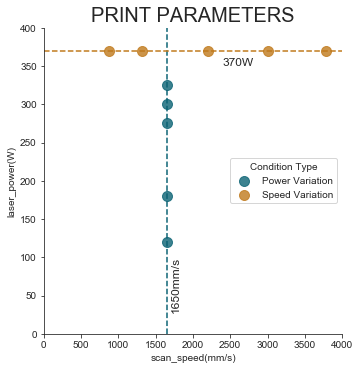

In [37]:
# Plot print parameters, comparing scan speed vs. laser power

pp_colors = {'PV':colors.get('blue'), 'SV':colors.get('orange')}

sns.set_style("ticks")

_ = sns.lmplot('scan_speed(mm/s)', # Horizontal Axis
           'laser_power(W)', # Vertical Axis
           data=pp, # Data Source
           hue='cond_type', # Color Markers
           palette=pp_colors, # Color Dictionary
           scatter_kws={'s': 100}, # Set Marker Size
           fit_reg=False, # Don't Fix a Regression Line
           legend=False # Remove Default Legend
          )

_ = plt.title('PRINT PARAMETERS', fontsize=tt_fs)
_ = plt.xlim(0, 4000)
_ = plt.ylim(0, 400)
_ = plt.legend(['Power Variation','Speed Variation'], 
           title='Condition Type', loc='right', frameon=True)

# add vertical constant line for power with label
_ = plt.axvline(x=1650, color=pp_colors.get('PV'), linestyle='dashed')
_ = plt.text(1700, 90, '1650mm/s', fontsize=12, rotation=90)

# add horizontal constant line for speed with label
_ = plt.axhline(y=370, color=pp_colors.get('SV'), linestyle='dashed')
_ = plt.text(2400, 350, '370W', fontsize=12)

# plt.savefig('pp.jpeg', dpi=1000, bbox_inches="tight")

## Material Property Plot

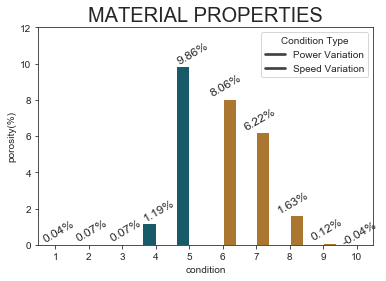

In [38]:
# Plot material properties, porosity vs. condition

sns.set_style("ticks")

ax = sns.barplot(x=combined_df.index, # Horizontal Axis
                 y='porosity(%)', # Vertical Axis
                 data=combined_df, # Data Source
                 hue='cond_type', # Color Markers
                 palette=pp_colors) # Color Dictionary

_ = plt.title('MATERIAL PROPERTIES', fontsize=tt_fs)
_ = plt.ylim(0, 12)
_ = plt.legend(['Power Variation','Speed Variation'], 
           title='Condition Type', 
               loc='upper right', 
               frameon=True)

for index, row in combined_df.iterrows():
    x = index - 1
    y = row['porosity(%)']
    ax.text(x+0.1, y+1, 
            str(round(y,2))+'%',
            ha='center',
            fontsize=12,
            rotation=30)

# plt.savefig('mp.jpeg', dpi=1000, bbox_inches="tight")

## Create Dot Plot Function

In [39]:
# This function is to be reused to create dot graphs

def create_lmplot(plot_dict):

    sns.set_style("ticks")

    sns.lmplot(plot_dict['x_data'], # Horizontal Axis
               plot_dict['y_data'], # Vertical Axis
               data=plot_dict['table'], # Data Source
               hue=plot_dict['hue'], # Color Markers
               scatter_kws={'s': 100}, # Set Marker Size
               fit_reg=True, # Don't Fix a Regression Line
               legend=False # Remove Default Legend
              )
    plt.title(plot_dict['title'], fontsize=tt_fs)
    plt.xlim(plot_dict['x_lim'][0], plot_dict['x_lim'][1])
    plt.ylim(plot_dict['y_lim'][0], plot_dict['y_lim'][1])
    plt.legend(title=plot_dict['legend_title'], 
               loc='center left', 
               bbox_to_anchor=(1.0, 0., 1.0, 1.0)
              )


## Porosity vs. Laser Power & Speed

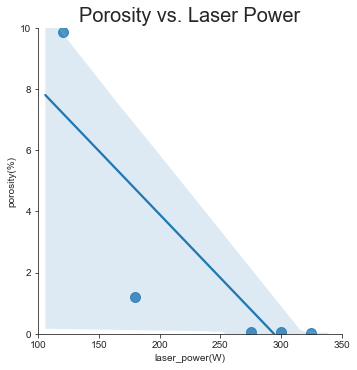

In [40]:
# plot laser power vs. porosity

mpm_pp_mp_pv = combined_df[combined_df['cond_type']=='PV']

sns.set_style("ticks")

_ = sns.lmplot('laser_power(W)', # Horizontal Axis
           'porosity(%)', # Vertical Axis
           data=mpm_pp_mp_pv, # Data Source
           palette=pp_colors, # Color Dictionary
           scatter_kws={'s': 100}, # Set Marker Size
           fit_reg=True, # Don't Fix a Regression Line
           legend=False # Remove Default Legend
          )

_ = plt.title('Porosity vs. Laser Power', fontsize=tt_fs)
_ = plt.xlim(100, 350)
_ = plt.ylim(0, 10)

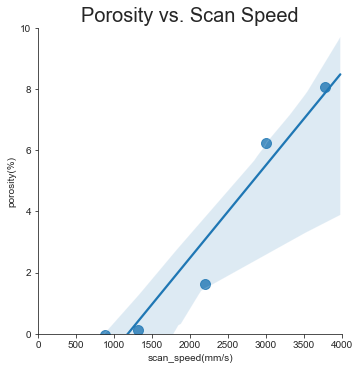

In [41]:
# plot scan speed vs. porosity

mpm_pp_mp_sv = combined_df[combined_df['cond_type']=='SV']

sns.set_style("ticks")

_ = sns.lmplot('scan_speed(mm/s)', # Horizontal Axis
           'porosity(%)', # Vertical Axis
           data=mpm_pp_mp_sv, # Data Source
           palette=pp_colors, # Color Dictionary
           scatter_kws={'s': 100}, # Set Marker Size
           fit_reg=True, # Don't Fix a Regression Line
           legend=False # Remove Default Legend
          )

_ = plt.title('Porosity vs. Scan Speed', fontsize=tt_fs)
_ = plt.xlim(0, 4000)
_ = plt.ylim(0, 10)


## Intensity Plots

### Short Intensity vs. Print Parameters vs. Porosity

In [42]:
# Create df for short wavelength intensities vs print parameters

# select all intensity column labels for the short wavelength
int_cols_s = [x for x in list(mpm_avg) if ('(counts/ms)'and '_s_') in x]

# select the columns to be ploted on the y axis
mpm_int_s = mpm_avg[int_cols_s]

# bring the column labels into the index
mpm_int_s = mpm_int_s.stack()

# join it to the print parameters df
mpm_int_s = pp.join(mpm_int_s.to_frame()).join(mp)

# set index and column names
mpm_int_s.index.names = ['condition','mask']
mpm_int_s = mpm_int_s.rename(columns = {0:'intensity(counts/ms)'})

mpm_int_s.head()

laser_power(W)  scan_speed(mm/s)  \
condition mask                                                       
1         int_s_p(counts/ms)                 325              1650   
          int_s_avg_3(counts/ms)             325              1650   
          int_s_avg_5(counts/ms)             325              1650   
2         int_s_p(counts/ms)                 300              1650   
          int_s_avg_3(counts/ms)             300              1650   

                                  hatch_spacing(mm) cond_type   led   ged  \
condition mask                                                              
1         int_s_p(counts/ms)                   0.09        PV  0.20  2.19   
          int_s_avg_3(counts/ms)               0.09        PV  0.20  2.19   
          int_s_avg_5(counts/ms)               0.09        PV  0.20  2.19   
2         int_s_p(counts/ms)                   0.09        PV  0.18  2.02   
          int_s_avg_3(counts/ms)               0.09        PV  0.18  2.02   

                                    ved  intensity(counts/ms)  porosity(%)  
condition mask                                                              
1         int_s_p(counts/ms)      72.95             115275.14        0.039  
          int_s_avg_3(counts/ms)  72.95              88425.75        0.039  
          int_s_avg_5(counts/ms)  72.95              58193.18        0.039  
2         int_s_p(counts/ms)      67.34             112043.37        0.068  
          int_s_avg_3(counts/ms)  67.34              84733.71        0.068

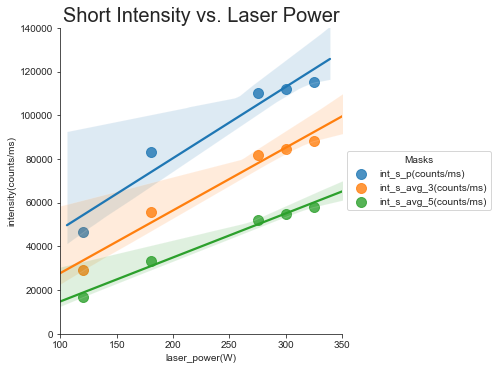

In [43]:
# Plot short intensity vs laser power

# select power variation (pv) rows
mpm_int_s_pv = mpm_int_s[mpm_int_s['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_int_s_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_int_s_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_s_pv,
                'hue' : 'mask',
                'title' : 'Short Intensity vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,140000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_s_pv)

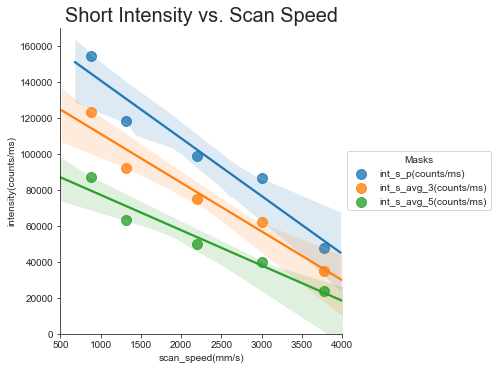

In [44]:
# Plot short intensity vs scan speed

# select speed variation (sv) rows
mpm_int_s_sv = mpm_int_s[mpm_int_s['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_int_s_sv.reset_index(level=1, inplace=True)

plot_dict_int_s_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_s_sv,
                'hue' : 'mask',
                'title' : 'Short Intensity vs. Scan Speed',
                'x_lim' : [500, 4000],
                'y_lim' : [0, 170000],
                'legend_title' : 'Masks'
             }
create_lmplot(plot_dict_int_s_sv)

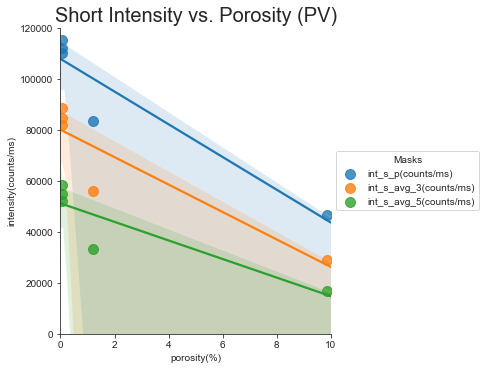

In [45]:
# Plot short intensity vs porosity (power variation)

# values used to create the plot
plot_dict_int_s_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_s_pv,
                'hue' : 'mask',
                'title' : 'Short Intensity vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,120000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_s_pv_mp)

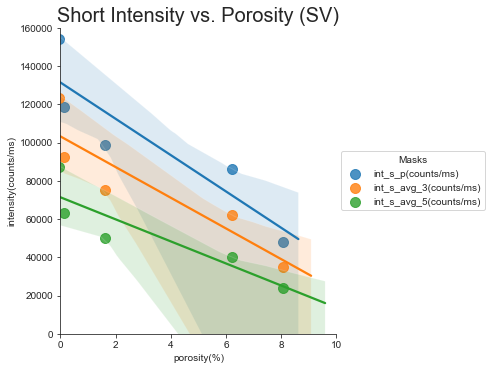

In [46]:
# Plot short intensity vs porosity (speed variation)

# values used to create the plot
plot_dict_int_s_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_s_sv,
                'hue' : 'mask',
                'title' : 'Short Intensity vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,160000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_s_sv_mp)

### Long Intensity vs. Print Parameters

In [47]:
# Create df for long wavelength intensities vs print parameters

# select all intensity column labels for the long wavelength
int_cols_l = [x for x in list(mpm_avg) if ('(counts/ms)'and '_l_') in x]

# select the columns to be ploted on the y axis
mpm_int_l = mpm_avg[int_cols_l]

# bring the column labels into the index
mpm_int_l = mpm_int_l.stack()

# join it to the print parameters df
mpm_int_l = pp.join(mpm_int_l.to_frame()).join(mp)

# set index and column names
mpm_int_l.index.names = ['condition','mask']
mpm_int_l = mpm_int_l.rename(columns = {0:'intensity(counts/ms)'})

mpm_int_l.head()

laser_power(W)  scan_speed(mm/s)  \
condition mask                                                       
1         int_l_p(counts/ms)                 325              1650   
          int_l_avg_3(counts/ms)             325              1650   
          int_l_avg_5(counts/ms)             325              1650   
2         int_l_p(counts/ms)                 300              1650   
          int_l_avg_3(counts/ms)             300              1650   

                                  hatch_spacing(mm) cond_type   led   ged  \
condition mask                                                              
1         int_l_p(counts/ms)                   0.09        PV  0.20  2.19   
          int_l_avg_3(counts/ms)               0.09        PV  0.20  2.19   
          int_l_avg_5(counts/ms)               0.09        PV  0.20  2.19   
2         int_l_p(counts/ms)                   0.09        PV  0.18  2.02   
          int_l_avg_3(counts/ms)               0.09        PV  0.18  2.02   

                                    ved  intensity(counts/ms)  porosity(%)  
condition mask                                                              
1         int_l_p(counts/ms)      72.95              62341.44        0.039  
          int_l_avg_3(counts/ms)  72.95              48092.71        0.039  
          int_l_avg_5(counts/ms)  72.95              32834.51        0.039  
2         int_l_p(counts/ms)      67.34              60296.52        0.068  
          int_l_avg_3(counts/ms)  67.34              45928.36        0.068

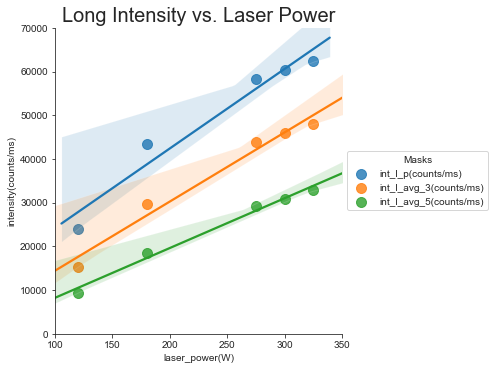

In [48]:
# Plot long intensity vs laser power

# select power variation (pv) rows
mpm_int_l_pv = mpm_int_l[mpm_int_l['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_int_l_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_int_l_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_l_pv,
                'hue' : 'mask',
                'title' : 'Long Intensity vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,70000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_l_pv)

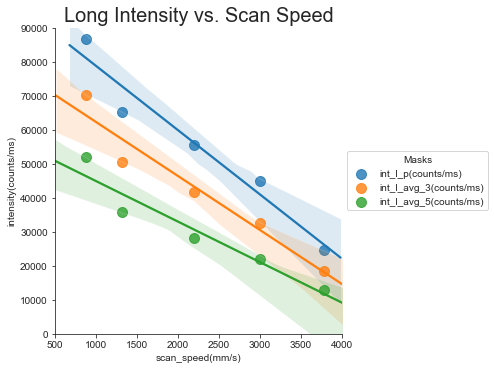

In [49]:
# Plot long intensity vs scan speed

# select speed variation (sv) rows
mpm_int_l_sv = mpm_int_l[mpm_int_l['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_int_l_sv.reset_index(level=1, inplace=True)

plot_dict_int_l_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_l_sv,
                'hue' : 'mask',
                'title' : 'Long Intensity vs. Scan Speed',
                'x_lim' : [500, 4000],
                'y_lim' : [0, 90000],
                'legend_title' : 'Masks'
             }
create_lmplot(plot_dict_int_l_sv)

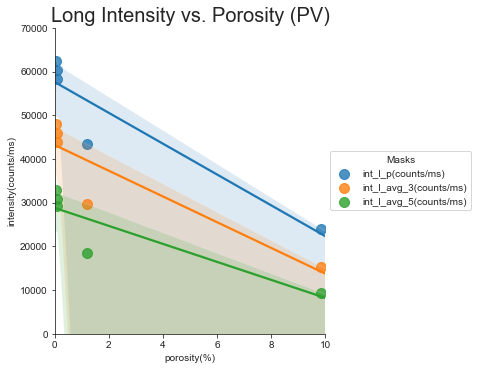

In [50]:
# Plot long intensity vs porosity (power variation)

# values used to create the plot
plot_dict_int_l_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_l_pv,
                'hue' : 'mask',
                'title' : 'Long Intensity vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,70000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_l_pv_mp)

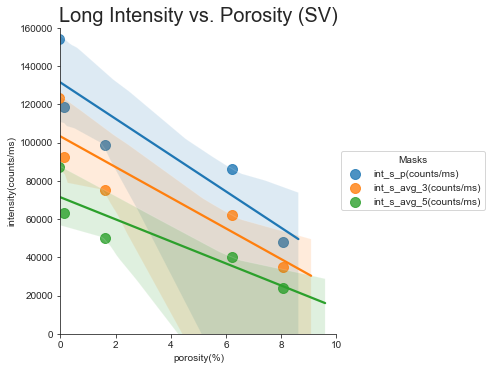

In [51]:
# Plot long intensity vs porosity (speed variation)

# values used to create the plot
plot_dict_int_l_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'intensity(counts/ms)',
                'table' : mpm_int_s_sv,
                'hue' : 'mask',
                'title' : 'Long Intensity vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,160000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_int_l_sv_mp)

## Temperature Plots

In [52]:
# Create df for temperatures vs print parameters

# select all temperature column labels
temp_cols = [x for x in list(mpm_avg) if '(C)' in x]

# select the columns to be ploted on the y axis
mpm_temp = mpm_avg[temp_cols]

# bring the column labels into the index
mpm_temp = mpm_temp.stack()

# join it to the print parameters df
mpm_temp = pp.join(mpm_temp.to_frame()).join(mp)

# set index and column names
mpm_temp.index.names = ['condition','threshold']
mpm_temp = mpm_temp.rename(columns = {0:'temp(C)'})

mpm_temp.head()

laser_power(W)  scan_speed(mm/s)  hatch_spacing(mm)  \
condition threshold                                                             
1         temp_peak(C)               325              1650               0.09   
          t1_temp_avg(C)             325              1650               0.09   
          t2_temp_avg(C)             325              1650               0.09   
          t3_temp_avg(C)             325              1650               0.09   
          t4_temp_avg(C)             325              1650               0.09   

                         cond_type  led   ged    ved  temp(C)  porosity(%)  
condition threshold                                                         
1         temp_peak(C)          PV  0.2  2.19  72.95  3191.87        0.039  
          t1_temp_avg(C)        PV  0.2  2.19  72.95  1841.13        0.039  
          t2_temp_avg(C)        PV  0.2  2.19  72.95  2058.64        0.039  
          t3_temp_avg(C)        PV  0.2  2.19  72.95  2283.27        0.039  
          t4_temp_avg(C)        PV  0.2  2.19  72.95  2487.74        0.039

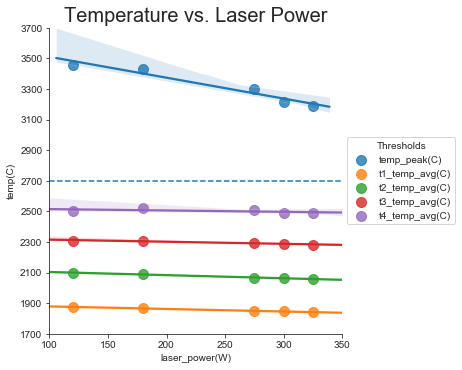

In [53]:
# Plot temperature vs laser power

# select power variation (pv) rows
mpm_temp_pv = mpm_temp[mpm_temp['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_temp_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_temp_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'temp(C)',
                'table' : mpm_temp_pv,
                'hue' : 'threshold',
                'title' : 'Temperature vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [1700,3700],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_temp_pv)

# set y tick marks
plt.yticks(range(1700, 3900, 200))

# add horizontal line for boiling point
plt.axhline(y=2700, linestyle='dashed', label='Boiling Point')

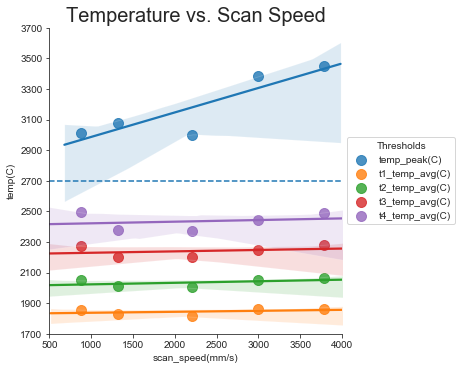

In [54]:
# Plot temperature vs scan speed

# select speed variation (sv) rows
mpm_temp_sv = mpm_temp[mpm_temp['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_temp_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_temp_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'temp(C)',
                'table' : mpm_temp_sv,
                'hue' : 'threshold',
                'title' : 'Temperature vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [1700,3700],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_temp_sv)

# set y tick marks
plt.yticks(range(1700, 3900, 200))

# add horizontal line for boiling point
plt.axhline(y=2700, linestyle='dashed', label='Boiling Point')

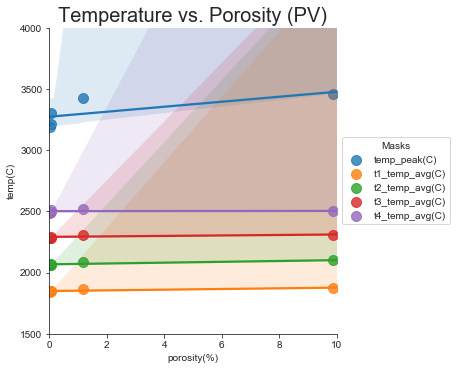

In [55]:
# Plot temperature vs porosity (power variation)

# values used to create the plot
plot_dict_temp_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'temp(C)',
                'table' : mpm_temp_pv,
                'hue' : 'threshold',
                'title' : 'Temperature vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [1500,4000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_temp_pv_mp)

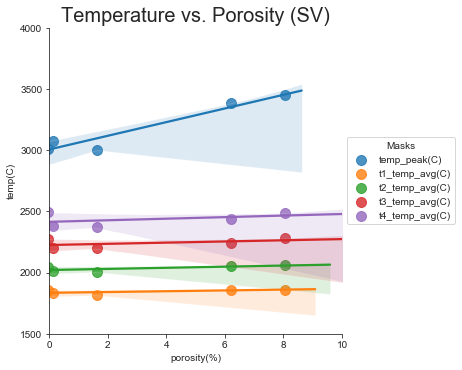

In [56]:
# Plot temperature vs porosity (speed variation)

# values used to create the plot
plot_dict_temp_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'temp(C)',
                'table' : mpm_temp_sv,
                'hue' : 'threshold',
                'title' : 'Temperature vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [1500,4000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_temp_sv_mp)

## Dimension Plots

### Length

In [57]:
# Create df for length vs print parameters

# select column labels
length_cols = [x for x in list(mpm_avg) if 'length' in x]

# select the columns to be ploted on the y axis
mpm_length = mpm_avg[length_cols]

# bring the column labels into the index
mpm_length = mpm_length.stack()

# join it to the print parameters df
mpm_length = pp.join(mpm_length.to_frame()).join(mp)

# set index and column names
mpm_length.index.names = ['condition','threshold']
mpm_length = mpm_length.rename(columns = {0:'distance(microns)'})

mpm_length.head()

laser_power(W)  scan_speed(mm/s)  \
condition threshold                                              
1         t1_length(microns)             325              1650   
          t2_length(microns)             325              1650   
          t3_length(microns)             325              1650   
          t4_length(microns)             325              1650   
2         t1_length(microns)             300              1650   

                              hatch_spacing(mm) cond_type   led   ged    ved  \
condition threshold                                                            
1         t1_length(microns)               0.09        PV  0.20  2.19  72.95   
          t2_length(microns)               0.09        PV  0.20  2.19  72.95   
          t3_length(microns)               0.09        PV  0.20  2.19  72.95   
          t4_length(microns)               0.09        PV  0.20  2.19  72.95   
2         t1_length(microns)               0.09        PV  0.18  2.02  67.34   

                              distance(microns)  porosity(%)  
condition threshold                                           
1         t1_length(microns)            1749.28        0.039  
          t2_length(microns)            1169.64        0.039  
          t3_length(microns)             665.63        0.039  
          t4_length(microns)             397.33        0.039  
2         t1_length(microns)            1693.33        0.068

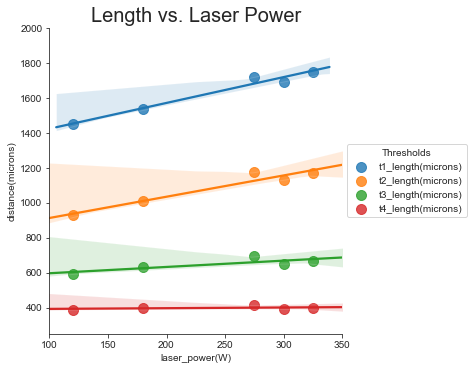

In [58]:
# Plot length vs laser power

# select power variation (pv) rows
mpm_length_pv = mpm_length[mpm_length['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_length_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_length_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'distance(microns)',
                'table' : mpm_length_pv,
                'hue' : 'threshold',
                'title' : 'Length vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [250,2000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_length_pv)

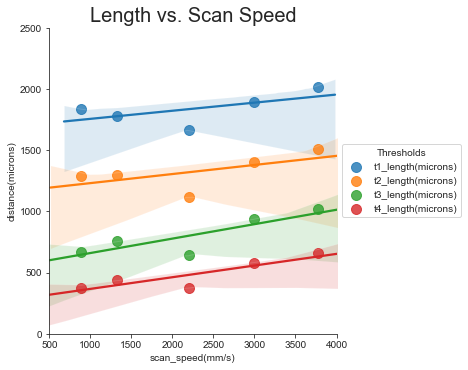

In [59]:
# Plot length vs scan speed

# select speed variation (sv) rows
mpm_length_sv = mpm_length[mpm_length['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_length_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_length_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'distance(microns)',
                'table' : mpm_length_sv,
                'hue' : 'threshold',
                'title' : 'Length vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [0,2500],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_length_sv)

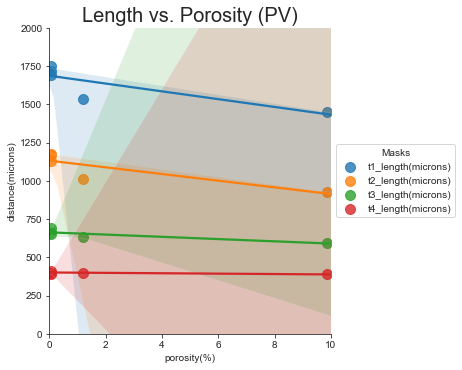

In [60]:
# Plot length vs porosity (power variation)

# values used to create the plot
plot_dict_length_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'distance(microns)',
                'table' : mpm_length_pv,
                'hue' : 'threshold',
                'title' : 'Length vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,2000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_length_pv_mp)

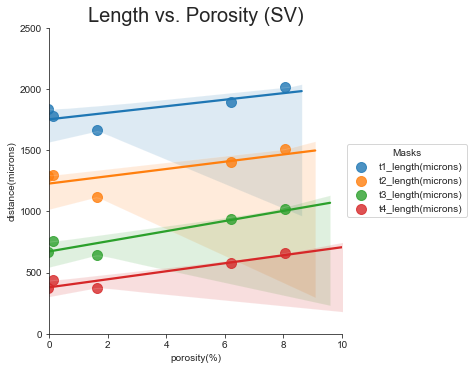

In [61]:
# Plot length vs porosity (speed variation)

# values used to create the plot
plot_dict_length_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'distance(microns)',
                'table' : mpm_length_sv,
                'hue' : 'threshold',
                'title' : 'Length vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,2500],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_length_sv_mp)

### Width

In [62]:
# Create df for width vs print parameters

# select column labels
width_cols = [x for x in list(mpm_avg) if 'width' in x]

# select the columns to be ploted on the y axis
mpm_width = mpm_avg[width_cols]

# bring the column labels into the index
mpm_width = mpm_width.stack()

# join it to the print parameters df
mpm_width = pp.join(mpm_width.to_frame()).join(mp)

# set index and column names
mpm_width.index.names = ['condition','threshold']
mpm_width = mpm_width.rename(columns = {0:'distance(microns)'})

mpm_width.head()

laser_power(W)  scan_speed(mm/s)  \
condition threshold                                             
1         t1_width(microns)             325              1650   
          t2_width(microns)             325              1650   
          t3_width(microns)             325              1650   
          t4_width(microns)             325              1650   
2         t1_width(microns)             300              1650   

                             hatch_spacing(mm) cond_type   led   ged    ved  \
condition threshold                                                           
1         t1_width(microns)               0.09        PV  0.20  2.19  72.95   
          t2_width(microns)               0.09        PV  0.20  2.19  72.95   
          t3_width(microns)               0.09        PV  0.20  2.19  72.95   
          t4_width(microns)               0.09        PV  0.20  2.19  72.95   
2         t1_width(microns)               0.09        PV  0.18  2.02  67.34   

                             distance(microns)  porosity(%)  
condition threshold                                          
1         t1_width(microns)             791.96        0.039  
          t2_width(microns)             439.21        0.039  
          t3_width(microns)             278.58        0.039  
          t4_width(microns)             206.41        0.039  
2         t1_width(microns)             765.69        0.068

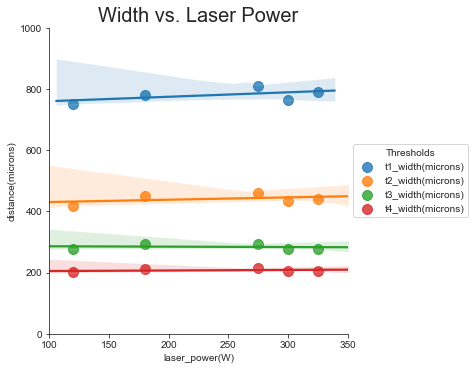

In [63]:
# Plot width vs laser power

# select power variation (pv) rows
mpm_width_pv = mpm_width[mpm_width['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_width_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_width_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'distance(microns)',
                'table' : mpm_width_pv,
                'hue' : 'threshold',
                'title' : 'Width vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,1000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_width_pv)

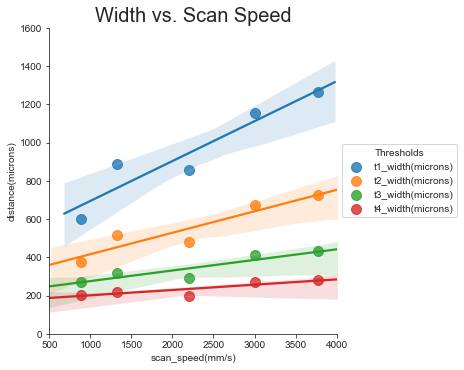

In [64]:
# Plot width vs scan speed

# select speed variation (sv) rows
mpm_width_sv = mpm_width[mpm_width['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_width_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_width_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'distance(microns)',
                'table' : mpm_width_sv,
                'hue' : 'threshold',
                'title' : 'Width vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [0,1600],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_width_sv)

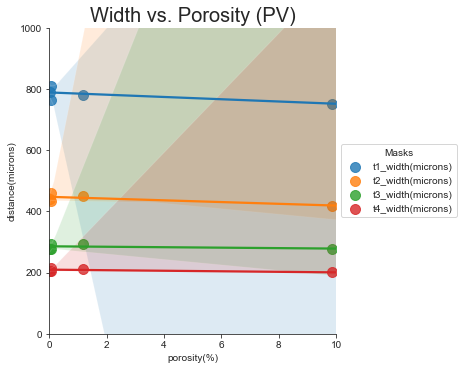

In [65]:
# Plot width vs porosity (power variation)

# values used to create the plot
plot_dict_width_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'distance(microns)',
                'table' : mpm_width_pv,
                'hue' : 'threshold',
                'title' : 'Width vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,1000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_width_pv_mp)

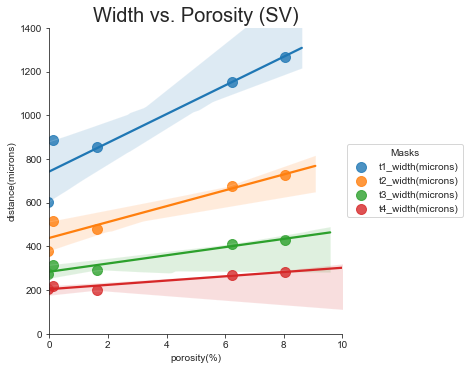

In [66]:
# Plot width vs porosity (speed variation)

# values used to create the plot
plot_dict_width_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'distance(microns)',
                'table' : mpm_width_sv,
                'hue' : 'threshold',
                'title' : 'Width vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,1400],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_width_sv_mp)

### Length-Width Ratio

In [67]:
# Create df for ratio vs print parameters

# select column labels
ratio_cols = [x for x in list(mpm_avg) if 'ratio' in x]

# select the columns to be ploted on the y axis
mpm_ratio = mpm_avg[ratio_cols]

# bring the column labels into the index
mpm_ratio = mpm_ratio.stack()

# join it to the print parameters df
mpm_ratio = pp.join(mpm_ratio.to_frame()).join(mp)

# set index and column names
mpm_ratio.index.names = ['condition','threshold']
mpm_ratio = mpm_ratio.rename(columns = {0:'ratio(-)'})

mpm_ratio.head()

laser_power(W)  scan_speed(mm/s)  hatch_spacing(mm)  \
condition threshold                                                             
1         t1_lw_ratio(-)             325              1650               0.09   
          t2_lw_ratio(-)             325              1650               0.09   
          t3_lw_ratio(-)             325              1650               0.09   
          t4_lw_ratio(-)             325              1650               0.09   
2         t1_lw_ratio(-)             300              1650               0.09   

                         cond_type   led   ged    ved  ratio(-)  porosity(%)  
condition threshold                                                           
1         t1_lw_ratio(-)        PV  0.20  2.19  72.95      2.38        0.039  
          t2_lw_ratio(-)        PV  0.20  2.19  72.95      2.78        0.039  
          t3_lw_ratio(-)        PV  0.20  2.19  72.95      2.37        0.039  
          t4_lw_ratio(-)        PV  0.20  2.19  72.95      1.90        0.039  
2         t1_lw_ratio(-)        PV  0.18  2.02  67.34      2.36        0.068

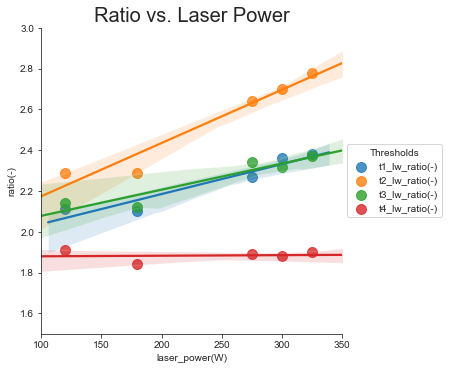

In [68]:
# Plot ratio vs laser power

# select power variation (pv) rows
mpm_ratio_pv = mpm_ratio[mpm_ratio['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_ratio_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_ratio_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'ratio(-)',
                'table' : mpm_ratio_pv,
                'hue' : 'threshold',
                'title' : 'Ratio vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [1.5,3],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_ratio_pv)

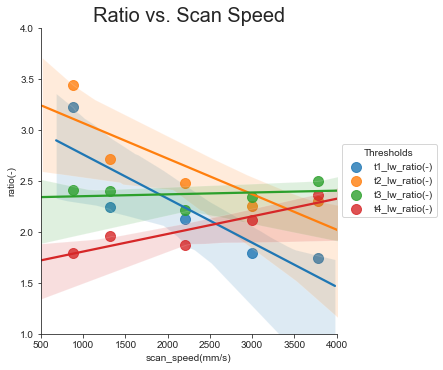

In [69]:
# Plot ratio vs scan speed

# select speed variation (sv) rows
mpm_ratio_sv = mpm_ratio[mpm_ratio['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_ratio_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_ratio_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'ratio(-)',
                'table' : mpm_ratio_sv,
                'hue' : 'threshold',
                'title' : 'Ratio vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [1,4],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_ratio_sv)

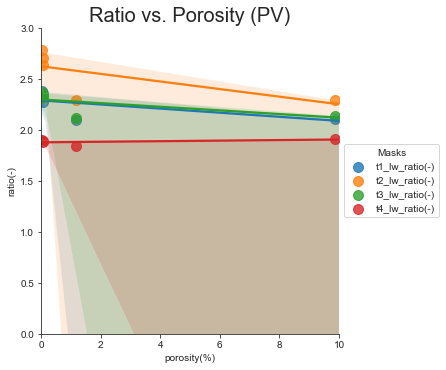

In [70]:
# Plot width vs porosity (power variation)

# values used to create the plot
plot_dict_ratio_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'ratio(-)',
                'table' : mpm_ratio_pv,
                'hue' : 'threshold',
                'title' : 'Ratio vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,3],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_ratio_pv_mp)

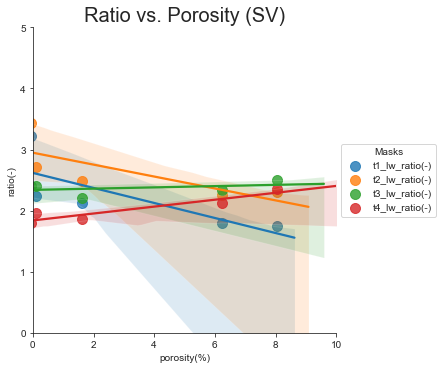

In [71]:
# Plot ratio vs porosity (speed variation)

# values used to create the plot
plot_dict_ratio_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'ratio(-)',
                'table' : mpm_ratio_sv,
                'hue' : 'threshold',
                'title' : 'Ratio vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,5],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_ratio_sv_mp)

### Area

In [72]:
# Create df for area vs print parameters

# select column labels
area_cols = [x for x in list(mpm_avg) if all(['area(microns2)' in x, 'sat' not in x])]

# select the columns to be ploted on the y axis
mpm_area = mpm_avg[area_cols]

# bring the column labels into the index
mpm_area = mpm_area.stack()

# join it to the print parameters df
mpm_area = pp.join(mpm_area.to_frame()).join(mp)

# set index and column names
mpm_area.index.names = ['condition','threshold']
mpm_area = mpm_area.rename(columns = {0:'area(microns2)'})

mpm_area.head()

laser_power(W)  scan_speed(mm/s)  \
condition threshold                                             
1         t1_area(microns2)             325              1650   
          t2_area(microns2)             325              1650   
          t3_area(microns2)             325              1650   
          t4_area(microns2)             325              1650   
2         t1_area(microns2)             300              1650   

                             hatch_spacing(mm) cond_type   led   ged    ved  \
condition threshold                                                           
1         t1_area(microns2)               0.09        PV  0.20  2.19  72.95   
          t2_area(microns2)               0.09        PV  0.20  2.19  72.95   
          t3_area(microns2)               0.09        PV  0.20  2.19  72.95   
          t4_area(microns2)               0.09        PV  0.20  2.19  72.95   
2         t1_area(microns2)               0.09        PV  0.18  2.02  67.34   

                             area(microns2)  porosity(%)  
condition threshold                                       
1         t1_area(microns2)       866129.53        0.039  
          t2_area(microns2)       331775.37        0.039  
          t3_area(microns2)       132710.74        0.039  
          t4_area(microns2)        63239.05        0.039  
2         t1_area(microns2)       801132.24        0.068

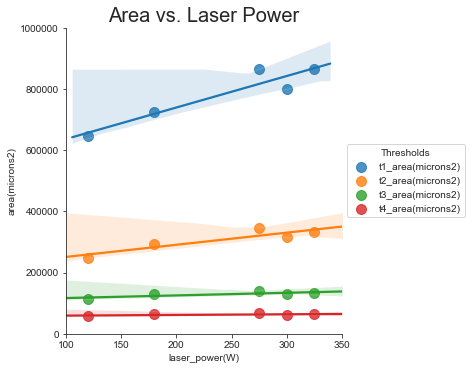

In [73]:
# Plot area vs laser power

# select power variation (pv) rows
mpm_area_pv = mpm_area[mpm_area['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_area_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_area_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'area(microns2)',
                'table' : mpm_area_pv,
                'hue' : 'threshold',
                'title' : 'Area vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,1000000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_area_pv)

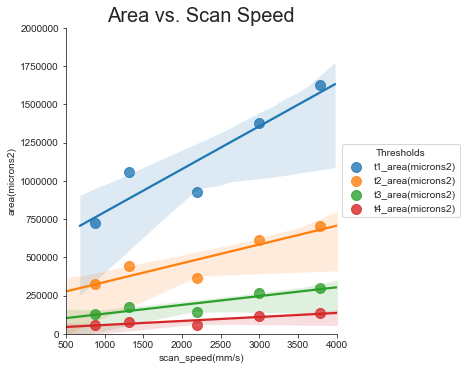

In [74]:
# Plot area vs scan speed

# select power variation (sv) rows
mpm_area_sv = mpm_area[mpm_area['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_area_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_area_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'area(microns2)',
                'table' : mpm_area_sv,
                'hue' : 'threshold',
                'title' : 'Area vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [0,2000000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_area_sv)

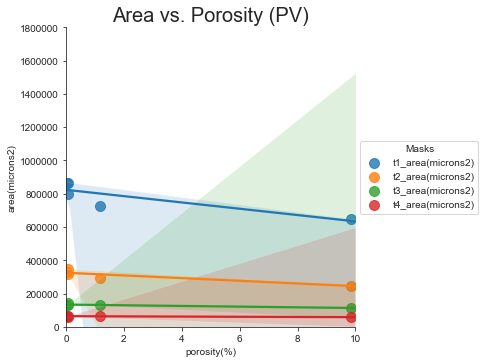

In [75]:
# Plot area vs porosity (power variation)

# values used to create the plot
plot_dict_area_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'area(microns2)',
                'table' : mpm_area_pv,
                'hue' : 'threshold',
                'title' : 'Area vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,1800000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_area_pv_mp)

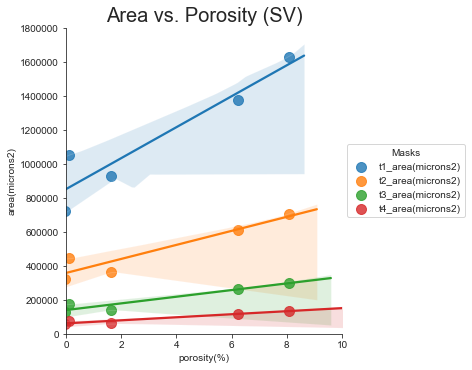

In [76]:
# Plot area vs porosity (speed variation)

# values used to create the plot
plot_dict_area_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'area(microns2)',
                'table' : mpm_area_sv,
                'hue' : 'threshold',
                'title' : 'Area vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,1800000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_area_sv_mp)

### Number of Satalites

In [77]:
# Create df for sat area vs print parameters

# select column labels
sat_num_cols = [x for x in list(mpm_avg) if 'sat_num(-)' in x]

# select the columns to be ploted on the y axis
mpm_sat_num = mpm_avg[sat_num_cols]

# bring the column labels into the index
mpm_sat_num = mpm_sat_num.stack()

# join it to the print parameters df
mpm_sat_num = pp.join(mpm_sat_num.to_frame()).join(mp)

# set index and column names
mpm_sat_num.index.names = ['condition','threshold']
mpm_sat_num = mpm_sat_num.rename(columns = {0:'sat_num(-)'})

mpm_sat_num.head()

laser_power(W)  scan_speed(mm/s)  hatch_spacing(mm)  \
condition threshold                                                            
1         t1_sat_num(-)             325              1650               0.09   
          t2_sat_num(-)             325              1650               0.09   
          t3_sat_num(-)             325              1650               0.09   
          t4_sat_num(-)             325              1650               0.09   
2         t1_sat_num(-)             300              1650               0.09   

                        cond_type   led   ged    ved  sat_num(-)  porosity(%)  
condition threshold                                                            
1         t1_sat_num(-)        PV  0.20  2.19  72.95       25.34        0.039  
          t2_sat_num(-)        PV  0.20  2.19  72.95       11.93        0.039  
          t3_sat_num(-)        PV  0.20  2.19  72.95        5.59        0.039  
          t4_sat_num(-)        PV  0.20  2.19  72.95        1.76        0.039  
2         t1_sat_num(-)        PV  0.18  2.02  67.34       25.04        0.068

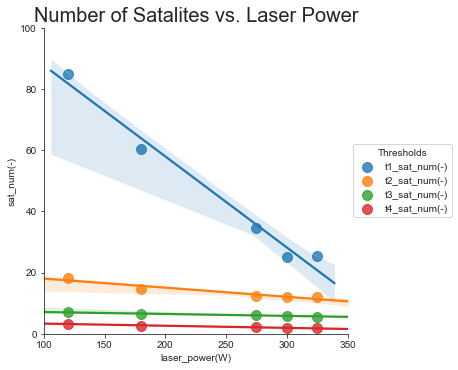

In [78]:
# Plot sat numbers vs laser power

# select power variation (pv) rows
mpm_sat_num_pv = mpm_sat_num[mpm_sat_num['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_sat_num_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_sat_num_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'sat_num(-)',
                'table' : mpm_sat_num_pv,
                'hue' : 'threshold',
                'title' : 'Number of Satalites vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,100],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_sat_num_pv)

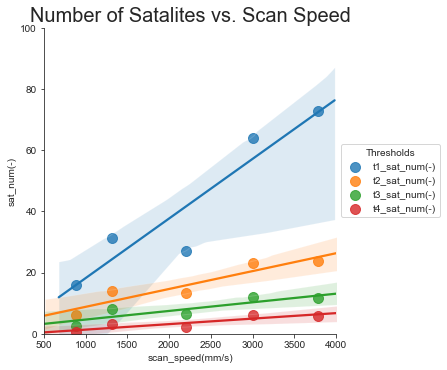

In [79]:
# Plot sat numbers vs scan speed

# select power variation (sv) rows
mpm_sat_num_sv = mpm_sat_num[mpm_sat_num['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_sat_num_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_sat_num_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'sat_num(-)',
                'table' : mpm_sat_num_sv,
                'hue' : 'threshold',
                'title' : 'Number of Satalites vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [0,100],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_sat_num_sv)

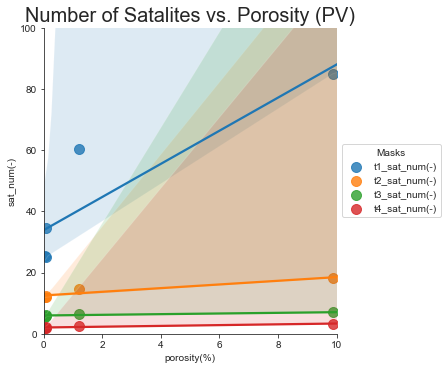

In [80]:
# Plot sat num vs porosity (power variation)

# values used to create the plot
plot_dict_sat_num_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'sat_num(-)',
                'table' : mpm_sat_num_pv,
                'hue' : 'threshold',
                'title' : 'Number of Satalites vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,100],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_sat_num_pv_mp)

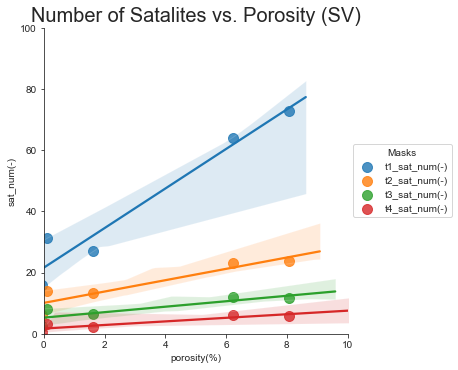

In [81]:
# Plot sat num vs porosity (speed variation)

# values used to create the plot
plot_dict_sat_num_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'sat_num(-)',
                'table' : mpm_sat_num_sv,
                'hue' : 'threshold',
                'title' : 'Number of Satalites vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,100],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_sat_num_sv_mp)

### Satalite Area

In [82]:
# Create df for sat area vs print parameters

# select column labels
sat_area_cols = [x for x in list(mpm_avg) if 'sat_area(microns2)' in x]

# select the columns to be ploted on the y axis
mpm_sat_area = mpm_avg[sat_area_cols]

# bring the column labels into the index
mpm_sat_area = mpm_sat_area.stack()

# join it to the print parameters df
mpm_sat_area = pp.join(mpm_sat_area.to_frame()).join(mp)

# set index and column names
mpm_sat_area.index.names = ['condition','threshold']
mpm_sat_area = mpm_sat_area.rename(columns = {0:'sat_area(microns2)'})

mpm_sat_area.head()

laser_power(W)  scan_speed(mm/s)  \
condition threshold                                                 
1         t1_sat_area(microns2)             325              1650   
          t2_sat_area(microns2)             325              1650   
          t3_sat_area(microns2)             325              1650   
          t4_sat_area(microns2)             325              1650   
2         t1_sat_area(microns2)             300              1650   

                                 hatch_spacing(mm) cond_type   led   ged  \
condition threshold                                                        
1         t1_sat_area(microns2)               0.09        PV  0.20  2.19   
          t2_sat_area(microns2)               0.09        PV  0.20  2.19   
          t3_sat_area(microns2)               0.09        PV  0.20  2.19   
          t4_sat_area(microns2)               0.09        PV  0.20  2.19   
2         t1_sat_area(microns2)               0.09        PV  0.18  2.02   

                                   ved  sat_area(microns2)  porosity(%)  
condition threshold                                                      
1         t1_sat_area(microns2)  72.95            95646.36        0.039  
          t2_sat_area(microns2)  72.95            51800.82        0.039  
          t3_sat_area(microns2)  72.95            22522.67        0.039  
          t4_sat_area(microns2)  72.95             6514.07        0.039  
2         t1_sat_area(microns2)  67.34            96046.18        0.068

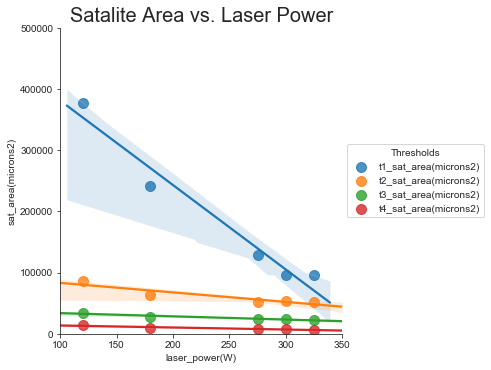

In [83]:
# Plot sat area vs laser power

# select power variation (pv) rows
mpm_sat_area_pv = mpm_sat_area[mpm_sat_area['cond_type'] == 'PV']

# convert the level_1 index into a column
mpm_sat_area_pv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_sat_area_pv = {
                'x_data' : 'laser_power(W)',
                'y_data' : 'sat_area(microns2)',
                'table' : mpm_sat_area_pv,
                'hue' : 'threshold',
                'title' : 'Satalite Area vs. Laser Power',
                'x_lim' : [100,350],
                'y_lim' : [0,500000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_sat_area_pv)

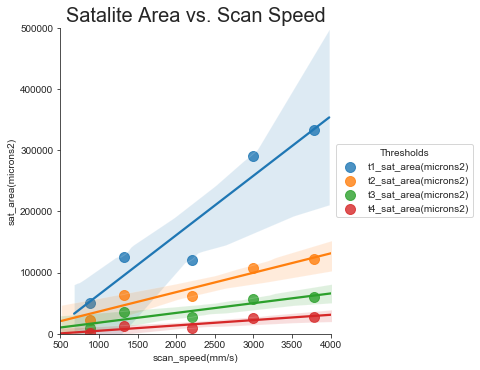

In [84]:
# Plot sat numbers vs scan speed

# select power variation (sv) rows
mpm_sat_area_sv = mpm_sat_area[mpm_sat_area['cond_type'] == 'SV']

# convert the level_1 index into a column
mpm_sat_area_sv.reset_index(level=1, inplace=True)

# values used to create the plot
plot_dict_sat_area_sv = {
                'x_data' : 'scan_speed(mm/s)',
                'y_data' : 'sat_area(microns2)',
                'table' : mpm_sat_area_sv,
                'hue' : 'threshold',
                'title' : 'Satalite Area vs. Scan Speed',
                'x_lim' : [500,4000],
                'y_lim' : [0,500000],
                'legend_title' : 'Thresholds'
             }

create_lmplot(plot_dict_sat_area_sv)

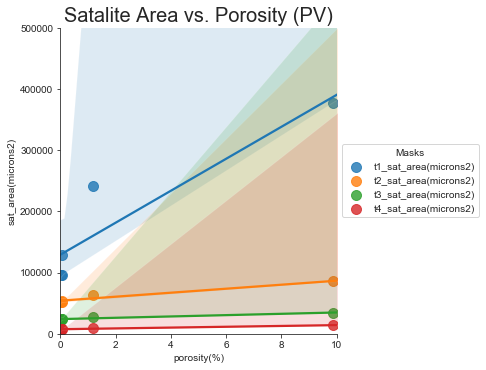

In [85]:
# Plot sat area vs porosity (power variation)

# values used to create the plot
plot_dict_sat_area_pv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'sat_area(microns2)',
                'table' : mpm_sat_area_pv,
                'hue' : 'threshold',
                'title' : 'Satalite Area vs. Porosity (PV)',
                'x_lim' : [0,10],
                'y_lim' : [0,500000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_sat_area_pv_mp)

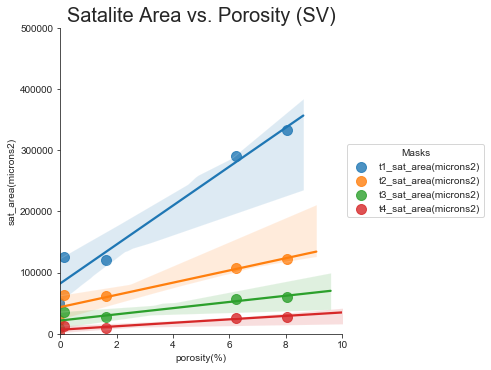

In [86]:
# Plot sat area vs porosity (speed variation)

# values used to create the plot
plot_dict_sat_area_sv_mp = {
                'x_data' : 'porosity(%)',
                'y_data' : 'sat_area(microns2)',
                'table' : mpm_sat_area_sv,
                'hue' : 'threshold',
                'title' : 'Satalite Area vs. Porosity (SV)',
                'x_lim' : [0,10],
                'y_lim' : [0,500000],
                'legend_title' : 'Masks'
             }

create_lmplot(plot_dict_sat_area_sv_mp)

# Correlation Plots

## Melt Pool Metric Correlations

In [87]:
mpm_corr = mpm.drop('scan_direction(xy)', axis=1)
mpm_corr.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 162284 entries, (1, 16, 1, 51) to (10, 45, 7, 5713)
Data columns (total 43 columns):
time(s)                         162284 non-null float64
int_s_p(counts/ms)              162284 non-null int32
int_l_p(counts/ms)              162284 non-null int32
int_s_avg_3(counts/ms)          162284 non-null int32
int_l_avg_3(counts/ms)          162284 non-null int32
int_s_avg_5(counts/ms)          162284 non-null int32
int_l_avg_5(counts/ms)          162284 non-null int32
region_mean_short(counts/ms)    162284 non-null int32
region_mean_long(counts/ms)     162284 non-null int32
temp_hybref(C)                  162284 non-null float64
temp_peak(C)                    162284 non-null float64
t1_temp_avg(C)                  162284 non-null float64
t1_length(microns)              162284 non-null float64
t1_width(microns)               162284 non-null float64
t1_lw_ratio(-)                  161360 non-null float64
t1_orient(degrees)              162284 no

## PP vs. MP

In [88]:
pp_mp = pd.concat([pp,mp], axis=1)
pp_mp.head()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,porosity(%)
condition,,,,,,,,
1,325,1650,0.09,PV,0.20,2.19,72.95,0.039
2,300,1650,0.09,PV,0.18,2.02,67.34,0.068
3,275,1650,0.09,PV,0.17,1.85,61.73,0.067
4,180,1650,0.09,PV,0.11,1.21,40.40,1.189
5,120,1650,0.09,PV,0.07,0.81,26.94,9.860


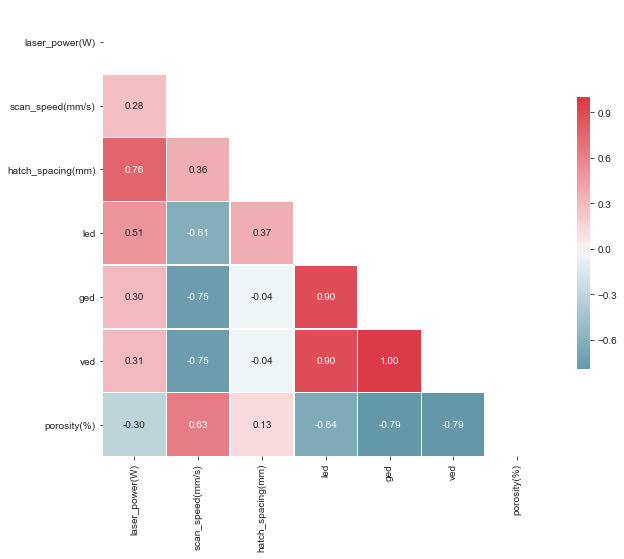

In [89]:
# Compute the correlation matrix
corr = pp_mp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

When correlating the Print Parameters to the Material Properties, GED and VED most directly correlate with Porosity, both values being -0.79. Since VED = GED / Layer Height, GED and VED have a correlation value of 1.00. This is because the Layer Height was kept constant in this experiment. 

Result: GED and Porosity Correlation Value = -0.79

## PP vs. MPM_Intensities vs. MP

In [90]:
# correlate PP vs. MPM_intensities vs. MP

mpm_int = mpm[mpm_int_cols].reset_index(level=['run','layer','frame'])
pp_mpm_int_mp = pd.concat([pp,mpm_int,mp], axis=1)
pp_mpm_int_mp.head()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,run,layer,frame,int_s_p(counts/ms),int_l_p(counts/ms),int_s_avg_3(counts/ms),int_l_avg_3(counts/ms),int_s_avg_5(counts/ms),int_l_avg_5(counts/ms),region_mean_short(counts/ms),region_mean_long(counts/ms),porosity(%)
condition,,,,,,,,,,,,,,,,,,,
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,51,111712,61425,80542,43009,53528,29562,89586,47854,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,52,118964,63268,79697,47197,49673,31120,93805,48014,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,53,127619,68878,90547,48840,55719,31673,99547,55255,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,54,127138,71442,91701,55122,57038,34140,99014,57831,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,55,126177,76171,99298,48844,57951,30553,100697,62527,0.039


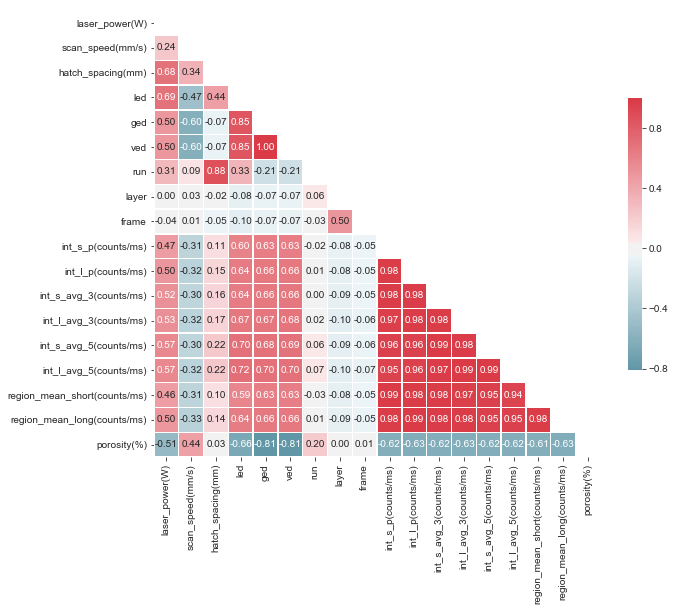

In [91]:
# Compute the correlation matrix
corr = pp_mpm_int_mp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

The Long Intensity Averaged over 5x5 pixels correlates fairly well with LED, 0.72. All the intensity columns correlate roughly the same with porosity, between -0.61 and -0.63.

## PP vs. MPM_peak vs. MP

In [92]:
# correlate PP vs. MPM_peak vs. MP

mpm_peak = mpm[mpm_peak_cols].reset_index(level=['run','layer','frame'])
pp_mpm_peak_mp = pd.concat([pp,mpm_peak,mp], axis=1)
pp_mpm_peak_mp.head()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,run,layer,frame,temp_hybref(C),temp_peak(C),porosity(%)
condition,,,,,,,,,,,,,
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,51,3117.0,3254.0,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,52,3319.9,3486.3,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,53,2952.9,3093.1,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,54,2758.2,2882.6,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,55,2553.4,2650.4,0.039


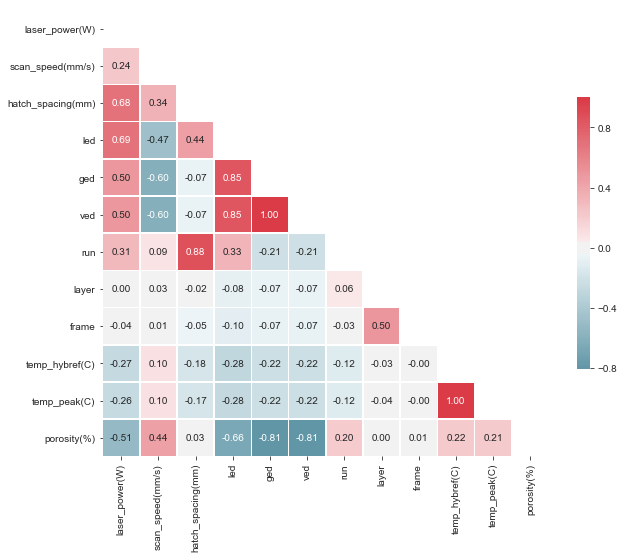

In [93]:
# Compute the correlation matrix
corr = pp_mpm_peak_mp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

Melt Pool Metrics: Hybrid Reference Temperature and Peak Temperature don't really correlate with Porosity or the Print Parameters very well.

## PP vs. MPM_t1 vs. MP

In [94]:
# correlate PP vs. MPM_peak vs. MP

mpm_t1_cols = [col for col in mpm.columns if 't1' in col]

mpm_t1 = mpm[mpm_t1_cols].reset_index(level=['run','layer','frame'])
pp_mpm_t1_mp = pd.concat([pp,mpm_t1,mp], axis=1)
pp_mpm_t1_mp.head()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,run,layer,frame,t1_temp_avg(C),t1_length(microns),t1_width(microns),t1_lw_ratio(-),t1_orient(degrees),t1_area(microns2),t1_sat_num(-),t1_sat_area(microns2),porosity(%)
condition,,,,,,,,,,,,,,,,,,,
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,51,1834.1,2319.33,572.76,4.05,-84.97,803926.21,5,15543.15,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,52,1856.9,2130.49,642.22,3.32,-86.22,894594.58,18,43175.41,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,53,1842.3,1695.94,420.71,4.03,88.93,453341.85,13,84623.81,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,54,1853.2,1155.88,359.25,3.22,-88.74,279776.68,16,51810.50,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,55,1804.5,962.99,323.71,2.97,89.20,198606.90,7,21587.71,0.039


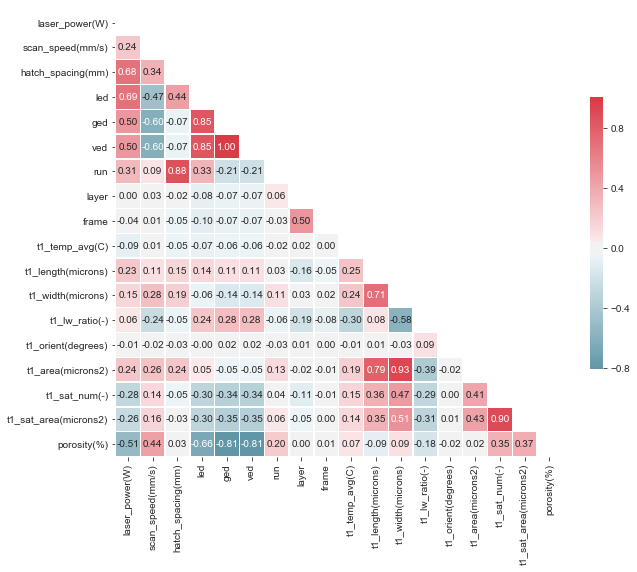

In [95]:
# Compute the correlation matrix
corr = pp_mpm_t1_mp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

The Melt Pool Metrics from Threshold 1 (t1) don't correlate well with Porosity, the two highest being the Number of Satellites  and the Satellite Area, at 0.35 and 0.37, respectively. Also, they don't correlate very well will the Print Parameters either.

Length, Width, LW_Ratio, Area
* Length vs. Width = 0.71

* Length vs. LW_Ratio = 0.08
* Length vs. Area = 0.79

* Width vs. LW_Ratio = -0.58
* Width vs. Area = 0.93

So Area is affected by both Length and Width, but by Width quite a bit more than Length. (0.93 vs 0.79) For how area is calculated, it makes sense to be highly correlated with Length and Width, but because of the tear dropped shape of the Melt Pool, the Width affects the Area more than the Length.

## PP vs. MPM_t2 vs. MP

In [96]:
# correlate PP vs. MPM_peak vs. MP

mpm_t2_cols = [col for col in mpm.columns if 't2' in col]

mpm_t2 = mpm[mpm_t2_cols].reset_index(level=['run','layer','frame'])
pp_mpm_t2_mp = pd.concat([pp,mpm_t2,mp], axis=1)
pp_mpm_t2_mp.head()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,run,layer,frame,t2_temp_avg(C),t2_length(microns),t2_width(microns),t2_lw_ratio(-),t2_orient(degrees),t2_area(microns2),t2_sat_num(-),t2_sat_area(microns2),porosity(%)
condition,,,,,,,,,,,,,,,,,,,
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,51,2058.8,1617.39,340.21,4.75,-89.43,303954.92,3,7771.57,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,52,2071.7,1579.52,387.05,4.08,-89.87,381670.66,5,11225.61,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,53,2079.6,818.71,305.40,2.68,87.56,162339.56,9,25905.25,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,54,2051.6,754.35,264.53,2.85,89.45,120891.16,1,2590.52,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,55,2050.8,411.40,219.34,1.88,87.43,63899.61,0,0.00,0.039


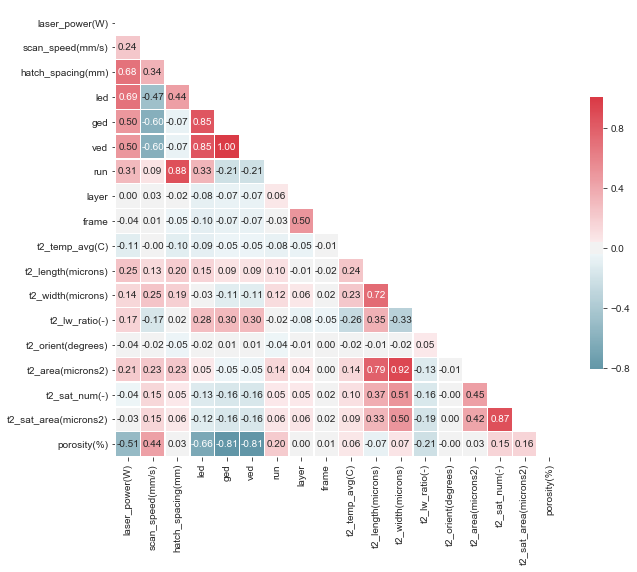

In [97]:
# Compute the correlation matrix
corr = pp_mpm_t2_mp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

The Melt Pool Metrics from Threshold 2 (t2) have an even worse correlation with Porosity than t1. Also, they don't correlate very well will the Print Parameters either.

## PP vs. MPM_t3 vs. MP

In [98]:
# correlate PP vs. MPM_peak vs. MP

mpm_t3_cols = [col for col in mpm.columns if 't3' in col]

mpm_t3 = mpm[mpm_t3_cols].reset_index(level=['run','layer','frame'])
pp_mpm_t3_mp = pd.concat([pp,mpm_t3,mp], axis=1)
pp_mpm_t3_mp.head()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,run,layer,frame,t3_temp_avg(C),t3_length(microns),t3_width(microns),t3_lw_ratio(-),t3_orient(degrees),t3_area(microns2),t3_sat_num(-),t3_sat_area(microns2),porosity(%)
condition,,,,,,,,,,,,,,,,,,,
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,51,2298.7,580.17,277.77,2.09,87.04,115710.11,7,13816.13,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,52,2318.2,664.56,313.23,2.12,-89.40,148523.42,4,19860.69,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,53,2344.5,381.99,237.07,1.61,83.12,66490.14,2,3454.03,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,54,2310.6,325.20,199.90,1.63,89.45,47492.96,0,0.00,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,55,2256.2,254.71,148.68,1.71,-89.65,28495.77,0,0.00,0.039


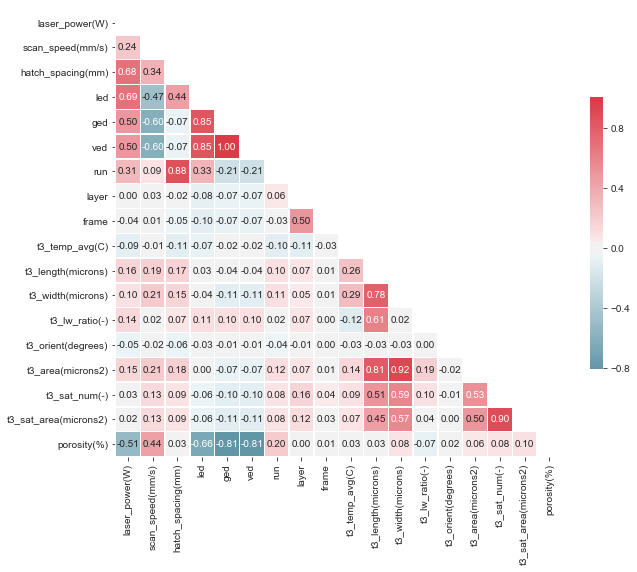

In [99]:
# Compute the correlation matrix
corr = pp_mpm_t3_mp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

The Melt Pool Metrics from Threshold 3 (t3) have an even worse correlation with Porosity than t2. Also, they don't correlate very well will the Print Parameters either.

## PP vs. MPM_t4 vs. MP

In [100]:
# correlate PP vs. MPM_peak vs. MP

mpm_t4_cols = [col for col in mpm.columns if 't4' in col]

mpm_t4 = mpm[mpm_t4_cols].reset_index(level=['run','layer','frame'])
pp_mpm_t4_mp = pd.concat([pp,mpm_t4,mp], axis=1)
pp_mpm_t4_mp.head()

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,run,layer,frame,t4_temp_avg(C),t4_length(microns),t4_width(microns),t4_lw_ratio(-),t4_orient(degrees),t4_area(microns2),t4_sat_num(-),t4_sat_area(microns2),porosity(%)
condition,,,,,,,,,,,,,,,,,,,
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,51,2533.7,342.22,217.89,1.57,78.60,53537.51,0,0.0,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,52,2540.6,483.17,225.95,2.14,84.59,75988.73,0,0.0,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,53,2546.9,286.38,172.57,1.66,83.45,37130.86,0,0.0,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,54,2527.4,215.84,147.10,1.47,-88.60,24178.23,0,0.0,0.039
1,325,1650,0.09,PV,0.2,2.19,72.95,16,1,55,2449.8,155.60,115.02,1.35,-68.40,12952.62,0,0.0,0.039


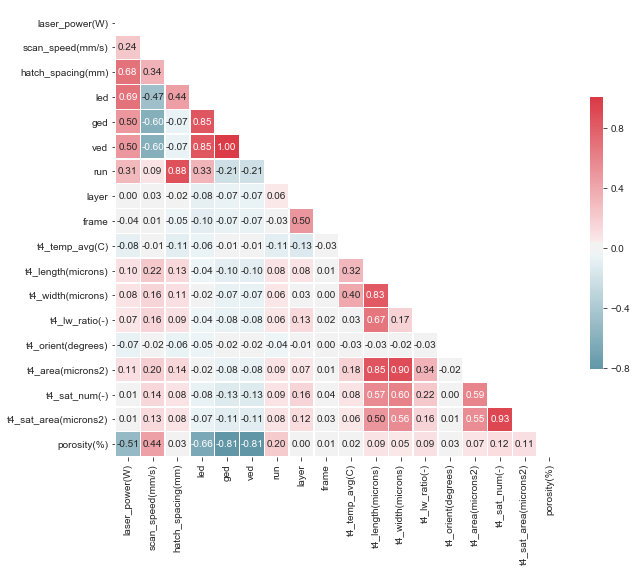

In [101]:
# Compute the correlation matrix
corr = pp_mpm_t4_mp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

The Melt Pool Metrics from Threshold 4 (t4) have a poor correlation with Porosity. Also, they don't correlate very well will the Print Parameters either.

PP vs. MP = GED/VED are the best indicators for Porosity (-0.79)

MPM vs. MP = Long Peak Intensity Pixel value is the best indicator of Porosity (-0.63)

PP vs. MPM = Long Intensity Averaged (5x5 mask) correlates fairly well with LED (0.72)


### MPM vs. MPM

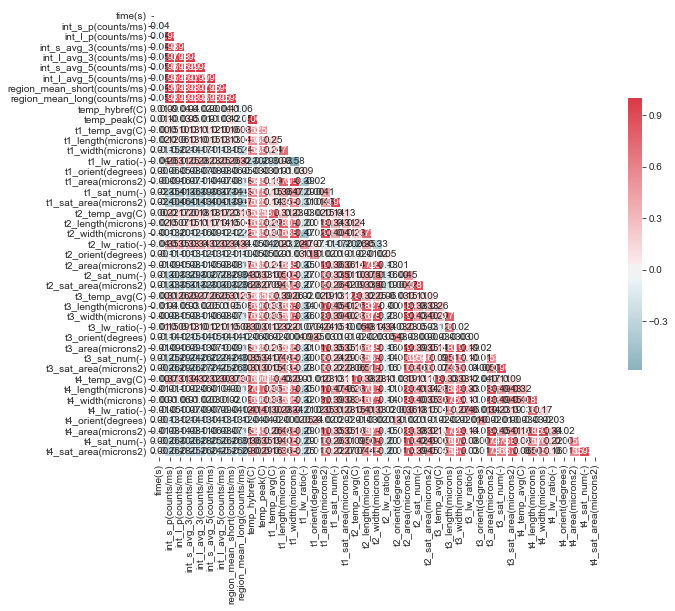

In [102]:
# Compute the correlation matrix
corr = mpm_corr.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

When comparing all the metrics against one another, this really isn't feasible, that's why they were broken down into sub groups.

# Modeling

## Steps
* 1) Linear Regression will be the modeling technique used for this project with a Continuous Variable. 
* 2) The data will be split into 2 categories (70-30). This will allow the data to be used to train and test the model.
* 3) Model parameters will be set to chosen values with a reasoning for each. 
* 4) The models will be created and a description for each. 
* 5) Interprete the models and any difficulties along with their meanings. Summarize the results and qualify each of the models in terms of accuracy. 
* 6) Revise the parameters settings with a new understanding of the models and their output and iterate through the process again until the best model is found.


In [103]:
# combined dataframe of: 
# --- Print Parameters
# --- Melt Pool Metrics
# --- Material Properties

model_df = combined_df.copy()
model_df['cond_type'] = model_df['cond_type'].map({'PV':0, 'SV':1}) # can only contain numerical values
model_df.loc[model_df['porosity(%)'] < 0, 'porosity(%)'] = 0 # technically porosity can't be less than zero
model_df

,laser_power(W),scan_speed(mm/s),hatch_spacing(mm),cond_type,led,ged,ved,int_s_p(counts/ms),int_l_p(counts/ms),int_s_avg_3(counts/ms),...,t3_sat_num(-),t3_sat_area(microns2),t4_temp_avg(C),t4_length(microns),t4_width(microns),t4_lw_ratio(-),t4_area(microns2),t4_sat_num(-),t4_sat_area(microns2),porosity(%)
condition,,,,,,,,,,,,,,,,,,,,,
1,325,1650,0.09,0,0.20,2.19,72.95,115275.14,62341.44,88425.75,...,5.59,22522.67,2487.74,397.33,206.41,1.90,63239.05,1.76,6514.07,0.039
2,300,1650,0.09,0,0.18,2.02,67.34,112043.37,60296.52,84733.71,...,5.80,23409.04,2492.11,391.81,205.13,1.88,61454.79,1.92,7130.33,0.068
3,275,1650,0.09,0,0.17,1.85,61.73,110104.99,58407.28,81792.17,...,6.28,24671.97,2510.24,413.65,214.02,1.89,66567.49,2.18,7734.37,0.067
4,180,1650,0.09,0,0.11,1.21,40.40,83300.67,43374.23,55928.03,...,6.49,27167.16,2521.89,399.42,212.45,1.84,63130.04,2.62,9604.12,1.189
5,120,1650,0.09,0,0.07,0.81,26.94,46522.53,24027.06,29044.97,...,7.01,34460.93,2501.97,388.35,200.48,1.91,57974.96,3.29,13919.61,9.860
6,370,3780,0.14,1,0.10,0.70,23.31,47806.60,24672.20,35048.63,...,11.61,60374.72,2488.13,656.57,282.92,2.36,136051.71,5.84,28026.04,8.060
7,370,3000,0.14,1,0.12,0.88,29.37,86427.24,45070.16,62152.44,...,11.97,56176.25,2441.41,582.05,271.31,2.12,117817.79,6.17,26353.64,6.225
8,370,2200,0.14,1,0.17,1.20,40.04,98608.57,55509.11,75088.63,...,6.46,27766.24,2375.30,375.55,198.32,1.87,60641.15,2.32,9717.46,1.630
9,370,1320,0.14,1,0.28,2.00,66.74,118457.64,65257.26,92400.60,...,8.05,36258.40,2379.41,438.27,220.72,1.96,77141.47,3.16,13216.18,0.115


## Import Libraries

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [105]:
# split data

# split data table into X and y
X = model_df.drop(['porosity(%)'], axis=1)
y = pd.DataFrame(model_df['porosity(%)'])

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

## Model 1: Linear Regression
* Accounts for how far labels are apart from one another
* Error = Squared Error - Sum the (distance)2 between the actual and the predicted

In [106]:
from sklearn.linear_model import LinearRegression

# initialize a LinearRegression model
lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [107]:
# feature coefficients
pd.DataFrame({'features': X.columns, 'est_coef': lm.coef_[0]})[['features', 'est_coef']]

,features,est_coef
0,laser_power(W),3.443130e-07
1,scan_speed(mm/s),-5.232445e-06
2,hatch_spacing(mm),-4.691401e-10
3,cond_type,-9.382803e-09
4,led,7.887918e-10
5,ged,1.618454e-08
6,ved,5.358307e-07
7,int_s_p(counts/ms),-7.544046e-05
8,int_l_p(counts/ms),-3.787816e-05
9,int_s_avg_3(counts/ms),8.718362e-05


In [108]:
lm.intercept_

array([-6.10060238])

In [109]:
y_pred = lm.predict(X_test)
# pred vs actual
y_pred_df = pd.DataFrame(y_pred, columns=['pred_porosity(%)']).set_index([pd.Index(y_test.index)])
y_pred_df

,pred_porosity(%)
condition,
3,-1.663046
10,-9.391963
7,5.116787


In [110]:
y_comb = pd.concat([y_test, y_pred_df], axis=1)
y_comb

,porosity(%),pred_porosity(%)
condition,,
3,0.067,-1.663046
10,0.000,-9.391963
7,6.225,5.116787


In [111]:
y_comb.loc[y_comb['pred_porosity(%)'] < 0, 'pred_porosity(%)'] = 0
y_comb

,porosity(%),pred_porosity(%)
condition,,
3,0.067,0.000000
10,0.000,0.000000
7,6.225,5.116787


In [112]:
# error

def calc_error(act, pred):

    # residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model
    rss = np.sum((act - pred) ** 2)

    # explained sum-of-squares measures the variance explained by the regression model
    ess = np.sum(pred - act) ** 2

    # 
    tss = ess + rss

    # coefficient of determination, the percentage of the variance in the response variable Y,
    # that can be explained by the linear regression model
    rsq = ess / tss

    # mean squared error - the averages of the sum-of-squares errors over their respective degrees of freedom
    # mse = rss / (N - K - 1)
    msr = rss / (10 - 44 - 1)

    # mean squared error - the averages of the sum-of-squares errors over their respective degrees of freedom
    mse = mean_squared_error(act, pred)
    
    # r squared with function
    rsquared = r2_score(act, pred)

    print('rss:', rss)
    print('ess:', ess)
    print('tss:', tss)
    print('rsq:', rsq)
    print('msr:', msr)
    print('mse:', mse)
    print('rsquared:', rsquared)


In [113]:
print('Test Data')
calc_error(y_comb['porosity(%)'], y_comb['pred_porosity(%)'])

Test Data
rss: 1.232624137373269
ess: 1.381124623994271
tss: 2.61374876136754
rsq: 0.5284075670959486
msr: -0.03521783249637911
mse: 0.4108747124577563
rsquared: 0.9517728017841522


### Model Review
* How do I assess the performance/accuracy of the model?
* If the model predicted a negative porosity, I set the value to zero, should I do that?

## Model 2: K Nearest Neighbor (KNN)
* Definition: Use the K Closest Data Points to Determine the Label/Category
* Parameter(s): K = # of Nearest Neighbors to Poll

In [114]:
from sklearn.neighbors import KNeighborsRegressor

In [115]:
# list of possible ks (number of nearest neighbors) 
knn_pos = [x for x in range(1, 6, 1)]

y_comb = y_test.copy()
ls_k_score = []

for k in knn_pos:
    
    # initiate the model
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # fit the model
    knn.fit(X_train, y_train)
    
    # predict the test results
    y_pred = knn.predict(X_test)
    
    # add the results to the df
    y_comb[k] = y_pred
    
    # calculate the score
    score = knn.score(X_test, y_test['porosity(%)'])
    
    # save the k value and score
    ls_k_score.append([k, score])
    
y_comb

,porosity(%),1,2,3,4,5
condition,,,,,,
3,0.067,0.039,0.8345,0.579000,0.7315,0.6082
10,0.000,0.068,0.0535,0.579000,0.7315,0.6082
7,6.225,8.060,4.0875,3.268333,2.4610,1.9824


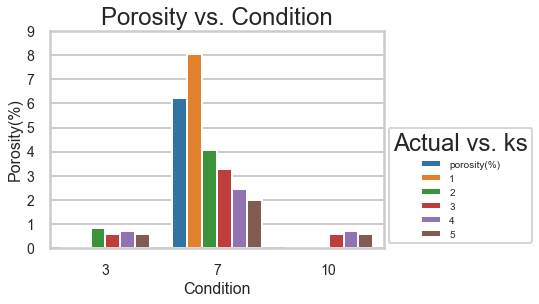

In [116]:
# plot the porosity results dependent upon k

temp = y_comb.copy() # make a temp df for the plot
temp.reset_index(inplace=True) # convert the index (labels) into a column
temp = pd.melt(temp, id_vars=['condition']) # melt the df into labels > campaign > value
temp

_ = sns.barplot(x='condition', 
                y='value', 
                data=temp, 
                hue='variable')

_ = plt.title('Porosity vs. Condition')
_ = plt.xlabel('Condition', fontsize=16)
_ = plt.ylabel('Porosity(%)', fontsize=16)
_ = plt.xticks(fontsize = 14)
_ = plt.yticks([x for x in range(0, 10, 1)], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0), fontsize = 10, title='Actual vs. ks')

In [117]:
# print the scores, dependent upon k
k_score = pd.DataFrame(ls_k_score, columns=['k', 'score'])
k_score

,k,score
0,1,0.868044
1,2,0.798079
2,3,0.634595
3,4,0.407468
4,5,0.269819


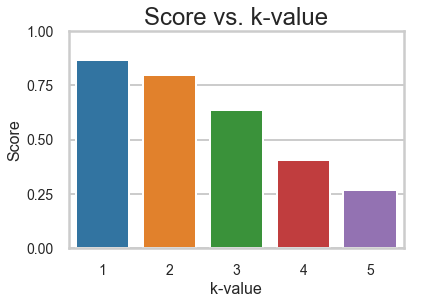

In [118]:
# plot the score vs. k

_ = sns.barplot(x='k', y='score', data=k_score)

_ = plt.title('Score vs. k-value')
_ = plt.xlabel('k-value', fontsize=16)
_ = plt.ylabel('Score', fontsize=16)
_ = plt.xticks(fontsize = 14)
_ = plt.yticks([.00, .25, .50, .75, 1.00], fontsize = 14)

### Model Review
After reviewing the scores and their respective k values, the model is most accurate when k=1. This means that the K Nearest Neighbor model works best when it only evaluates the nearest data point.

## Model 3: Support Vector Regression (SVR)
The advantages of support vector machines are:
* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.


The disadvantages of support vector machines are:
* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

In [119]:
from sklearn.svm import SVR

In [120]:
# multiple types of svr models with for loop

# kernel types
ls_kernel = ['rbf', 'linear', 'poly', 'sigmoid'] #, 'precomputed']

# list of possible ks (number of nearest neighbors) 
cs = [10**x for x in range(-7, 8, 1)]

y_comb = y_test.copy()
ls_k_c_score = []

for k in ls_kernel:
    for c in cs:
        if k in ['rbf', 'poly', 'sigmoid']:
            # initiate the model
            svr = SVR(kernel=k, C=c, gamma=0.1)
        else:
            svr = SVR(kernel=k, C=c)

        # fit the model
        svr.fit(X_train, y_train['porosity(%)'])

        # predict the test results
        y_pred = svr.predict(X_test)

        # add the results to the df
        y_comb[k + '_' + str(c)] = y_pred

        # calculate the score
        score = svr.score(X_test, y_test['porosity(%)'])

        # save the k value and score
        ls_k_c_score.append([k, c, score])
    
y_comb

,porosity(%),rbf_1e-07,rbf_1e-06,rbf_1e-05,rbf_0.0001,rbf_0.001,rbf_0.01,rbf_0.1,rbf_1,rbf_10,...,sigmoid_0.01,sigmoid_0.1,sigmoid_1,sigmoid_10,sigmoid_100,sigmoid_1000,sigmoid_10000,sigmoid_100000,sigmoid_1000000,sigmoid_10000000
condition,,,,,,,,,,,,,,,,,,,,,
3,0.067,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.0282,3.037286,...,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189
10,0.000,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.0282,3.037286,...,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189
7,6.225,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.0282,3.037286,...,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189,1.189


In [121]:
k_c_score = pd.DataFrame(ls_k_c_score, columns=['kernel', 'c', 'score'])
k_c_score

,kernel,c,score
0,rbf,1.000000e-07,-0.096844
1,rbf,1.000000e-06,-0.096844
2,rbf,1.000000e-05,-0.096844
3,rbf,1.000000e-04,-0.096844
4,rbf,1.000000e-03,-0.096844
5,rbf,1.000000e-02,-0.096844
6,rbf,1.000000e-01,-0.096844
7,rbf,1.000000e+00,-0.134167
8,rbf,1.000000e+01,-0.103704
9,rbf,1.000000e+02,-0.103704


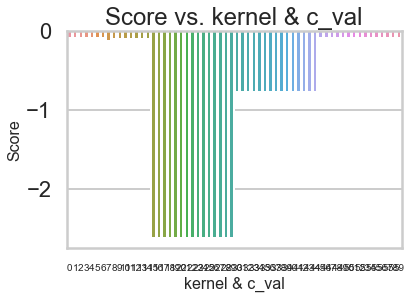

In [122]:
_ = sns.barplot(x=k_c_score.index, y='score', data=k_c_score)

_ = plt.title('Score vs. kernel & c_val')
_ = plt.xlabel('kernel & c_val', fontsize=16)
_ = plt.ylabel('Score', fontsize=16)
_ = plt.xticks(fontsize = 10)

In [123]:
pd.DataFrame(k_c_score.groupby(['kernel']).mean()['score'])

,score
kernel,
linear,-2.617676
poly,-0.781298
rbf,-0.102533
sigmoid,-0.096844


### Model Review
* All the scores are negative
* Regardless of the c_val, the score is constant
* Gamma was kept constant